<a href="https://colab.research.google.com/github/JardelDuque/tcc_puc-minas/blob/master/contratos_infraestrutura_distribuicao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho de Conclusão de Curso PUC-Minas
O objetivo desse notebook é descrever todo o procedimento para coleta, processamento/tratamento, análise/exploração e criação de modelos de machine learning necessários para produzir o TCC do curso de pós-graduação em Ciência de Dados e Big Data da PUC-Minas.
Esse notebook foi criado no ambiente do Google Colab, para facilitar a reprodutibilidade dos resultados, e foi utilizada a linguagem Python. As imagens de grafos foram criadas no software [yEd-Live](https://www.yworks.com/yed-live/), a partir de arquivos .graphml que são gerados neste notebook. 

In [1]:
!python --version

Python 3.7.10


## Bibliotecas
Nesse ponto inicial do código serão instaladas as bibliotecas em Python necessárias para a execução do projeto

In [2]:
#Para ultilizar a propriedade "bar_label", é necessária a versão mais recente
# 3.4.2 da biblioteca matplotlib. O Colab vem com a versão 3.2.2 instalada.
# Essa versão exige também a biblioteca imgaug na versão 0.2.5.
'''
##############ATENÇÃO:#############################
Pode ser necessário reiniciar o ambiente após a instalação dessa biblioteca
Ctrl+M .  --> reinicia o ambiente de execução
Ctrl+F9   --> roda todas as células, sequencialmente
'''
!pip install imgaug==0.2.5 -q
!pip install matplotlib==3.4.2 -q

In [3]:
#demais bibliotecas
!pip install mlxtend==0.18.0 -q
!pip install pyyed -q

Aqui são importadas as bibliotecas e funções necessárias à execução do código:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Colormap, to_hex, Normalize
from matplotlib.cm import get_cmap
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth , association_rules
import timeit
import pyyed
from google.colab import files

Serão também incluídos alguns comandos iniciais para melhor orientação da biblioteca matplotlib

In [5]:
%matplotlib inline

## Coleta de Dados


Os dados brutos foram baixados do site da ANP e carregados para um repositório no GitHub.
- Link para a planilha de contratos de cessão de espaço e carregamento rodoviário: http://www.anp.gov.br/arquivos/distribuicao-revenda/distr/cl/rdbc/cessao-espaco-carregamento.xlsx
- Link para a consulta de distribuidores autorizados: https://app.anp.gov.br/anp-cpl-web/public/simp/consulta-empresas-autorizadas/consulta.xhtml
- Link para o repositório no GitHub: https://github.com/JardelDuque/tcc_puc-minas 

### Dataset de Contratos
Importando o dataset de contratos:

In [6]:
# leitura do dataset de contratos e conversão em um dataframe do pandas 
file_link_contratos = "https://github.com/JardelDuque/tcc_puc-minas/blob/master/cessao-espaco-carregamento.xlsx?raw=true"
contratos = pd.read_excel(file_link_contratos, sheet_name="PLANILHA", skiprows=4)
contratos.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1426 entries, 0 to 1425
Data columns (total 31 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   TIPO DE CONTRATO                              1426 non-null   object        
 1   RAZÃO SOCIAL DA CEDENTE                       1426 non-null   object        
 2   CNPJ DA CEDENTE                               1426 non-null   object        
 3   N° AO DA CEDENTE                              1426 non-null   object        
 4   MUNICÍPIO DA CEDENTE                          1426 non-null   object        
 5   UF DA CEDENTE                                 1426 non-null   object        
 6   RAZÃO SOCIAL DA CESSIONÁRIA                   1426 non-null   object        
 7   CNPJ DA CESSIONÁRIA                           1426 non-null   object        
 8   N°  DA AEA CESSIONÁRIA                        1424 non-null   object

Explorando algumas características e exemplos dos valores de alguns campos selecionados do dataframe ```contratos```:

In [7]:
#valores únicos da coluna 'TIPO DE CONTRATO'
contratos['TIPO DE CONTRATO'].unique()

array(['CESSÃO DE ESPAÇO', 'CARREGAMENTO', 'CONTRATO ADITIVO'],
      dtype=object)

In [8]:
#exemplos de valores da coluna 'N° AO DA CEDENTE'
contratos['N° AO DA CEDENTE'].sample(5)

479     197/14
1086    444/19
247     287/13
576     986/15
1092    444/19
Name: N° AO DA CEDENTE, dtype: object

In [9]:
#exemplos de valores da coluna 'MUNICÍPIO DA CEDENTE'
contratos['MUNICÍPIO DA CEDENTE'].sample(5)

569            SANTARÉM
488           GUARULHOS
957     DUQUE DE CAXIAS
1178     SENADOR CANEDO
69                SINOP
Name: MUNICÍPIO DA CEDENTE, dtype: object

In [10]:
#exemplos de valores da coluna 'CNPJ DA CESSIONÁRIA'
contratos['CNPJ DA CESSIONÁRIA'].sample(5)

969     80.795.727/0015-47
474     04.677.033/0004-74
921     71.770.689/0009-39
1387    58.823.121/0001-13
653     01.466.091/0023-23
Name: CNPJ DA CESSIONÁRIA, dtype: object

In [11]:
#exemplos de valores da coluna 'N°  DA AEA CESSIONÁRIA'
contratos['N°  DA AEA CESSIONÁRIA'].sample(5)

691      645/15
338      672/15
223      606/15
1408    0639/15
366       34/18
Name: N°  DA AEA CESSIONÁRIA, dtype: object

In [12]:
#exemplos de valores da coluna 'INÍCIO CONTRATO (DESPACHO DOU ou OFÍCIO SDL)'
contratos['INÍCIO CONTRATO (DESPACHO DOU ou OFÍCIO SDL)'].sample(10)

761      Ofício SDL 104 de 16/01/2020
697     Ofício SDL 3251 de 16/12/2019
286      Ofício SDL 193 de 01/02/2019
1019    Ofício SDL 1227 de 20/05/2020
715     Ofício SDL 2199 de 30/12/2019
348      Ofício SDL 646 de 22/04/2019
372      Ofício SDL 593 de 15/04/2019
78                      Ofício 839/18
933      Ofício SDL 591 de 20/03/2020
827      Ofício SDL 220 de 30/01/2020
Name: INÍCIO CONTRATO (DESPACHO DOU ou OFÍCIO SDL), dtype: object

In [13]:
#exemplos de valores da coluna 'PROCESSO'
contratos['PROCESSO'].sample(5)

483     48610.211563/2019-98
490     48610.212008/2019-83
719     48610.223740/2019-89
701     48610.221183/2019-61
1409    48610.210904/2020-41
Name: PROCESSO, dtype: object

In [14]:
#exemplos de valores da coluna 'TÉRMINO CONTRATO'
contratos['TÉRMINO CONTRATO'].sample(5)

897    2024-01-14
1260   2024-07-01
742    2020-12-31
41     2020-10-28
136    2020-12-21
Name: TÉRMINO CONTRATO, dtype: datetime64[ns]

### Dataset de Distribuidores
Importando o dataset de distribuidores:

In [15]:
# leitura do dataset de distribuidores e conversão em um dataframe do pandas 
file_link_distribuidores = "https://github.com/JardelDuque/tcc_puc-minas/blob/master/Consulta%20P%C3%BAblica%20de%20Empresas%20Autorizadas%20-%20SDL.xls?raw=true"
distribuidores = pd.read_excel(file_link_distribuidores, sheet_name="Report", skiprows=5)
distribuidores.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   CNPJ                     159 non-null    object
 1   Razão Social             159 non-null    object
 2   Qualificação da Empresa  159 non-null    object
 3   Cep                      159 non-null    int64 
 4   Endereço da Matriz       159 non-null    object
 5   Número                   159 non-null    object
 6   Bairro                   158 non-null    object
 7   Complemento              131 non-null    object
 8   Município                159 non-null    object
 9   UF                       159 non-null    object
dtypes: int64(1), object(9)
memory usage: 12.5+ KB


In [16]:
#exemplos de valores da coluna 'CNPJ'
distribuidores['CNPJ'].sample(10)

89     07.243.624/0001-89
5      00.828.887/0001-00
31     01.973.067/0008-41
14     01.382.912/0001-38
25     01.787.793/0001-01
110    10.383.235/0001-63
64     04.201.170/0001-95
16     01.452.651/0001-85
83     06.958.597/0001-68
49     02.924.588/0001-03
Name: CNPJ, dtype: object

In [17]:
#exemplos de valores da coluna 'Razão Social'
distribuidores['Razão Social'].sample(5)

70                 FAN - DISTRIBUIDORA DE PETRÓLEO LTDA.
92             RODOIL DISTRIBUIDORA DE COMBUSTÍVEIS LTDA
28             DISTRIBUIDORA DE COMBUSTÍVEL TORRÃO LTDA.
105    PETRONOL DISTRIBUIDORA DE PETRÓLEO E ETANOL LTDA.
24            PANTERA DISTRIBUIDORA DE COMBUSTÍVEIS S/A.
Name: Razão Social, dtype: object

In [18]:
#Apresenta valores únicos da coluna 'Qualificação da Empresa'
print(distribuidores['Qualificação da Empresa'].unique())

['DISTRIBUIDOR DE COMBUSTÍVEIS']


In [19]:
#exemplos de valores da coluna 'Cep'
distribuidores['Cep'].sample(5)

114    78095140
141    75250000
76     75250000
16     79804970
94     13140000
Name: Cep, dtype: int64

In [20]:
#exemplos de valores da coluna 'Endereço da Matriz'
distribuidores['Endereço da Matriz'].sample(5)

40                         Rua   Antônio Raposo
130    Rodovia Alexandre BalbO, SP 328 - KM 327
158                            Rodovia   BR-369
100                                Rua   Pajurá
38                         SETOR INDUSTRIAL SUL
Name: Endereço da Matriz, dtype: object

In [21]:
#exemplos de valores da coluna 'Complemento'
distribuidores['Complemento'].sample(5)

77               SALA 2201
110                    NaN
8                  ANDAR 2
0             CONJUNTO 131
19     LOTE 23 - QUADRA 57
Name: Complemento, dtype: object

In [22]:
#exemplos de valores da coluna 'Município'
distribuidores['Município'].sample(5)

107    SENADOR CANEDO
93     CHA DE ALEGRIA
113          PAULINIA
33           PAULINIA
95             ESTEIO
Name: Município, dtype: object

## Processamento/Tratamento de Dados


Os datasets serão inicialmente tratados de maneira separada para, ao final, serem mesclados.

### Dataset de Contratos


A categoria `'TIPO DE CONTRATO' = 'CONTRATO ADITIVO'` tem apenas 16 representantes do total de 1426 linhas. 
Há alguns problemas com esses registros:
*   Não fica claro se esse CONTRATO ADITIVO modifica o contrato anterior para os novos valores de volume apresentados nessa linha, ou se os valores são adicionados;
*   Não é possível correlacionar sem erros um registro de CONTRATO ADITIVO com outro registro na planilha, mesmo se tentarmos cruzar a coluna PROCESSO RELACIONADO com a colune PROCESSO: a coluna PROCESSO não é chave primária, e um mesmo registro de contrato aditivo poderia ser atribuído a vários outros registros; Dessa forma, não é sequer possível identificar se o contrato aditivo faz referência a um contrato original do tipo 'CESSÃO DE ESPAÇO' ou de 'CARREGAMENTO'.

Tendo em vista a pequena quantidade de registros, a abordagem escolhida será a exclusão dessas 16 linhas, sem prejuízo para o objetivo e a qualidade da análise.

In [23]:
contratos[contratos['TIPO DE CONTRATO']=="CONTRATO ADITIVO"].info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 1342 to 1406
Columns: 31 entries, TIPO DE CONTRATO to PROCESSO RELACIONADO
dtypes: datetime64[ns](1), float64(9), int64(9), object(12)
memory usage: 4.0+ KB


In [24]:
contratos = contratos[contratos['TIPO DE CONTRATO']!="CONTRATO ADITIVO"]
contratos.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1410 entries, 0 to 1425
Columns: 31 entries, TIPO DE CONTRATO to PROCESSO RELACIONADO
dtypes: datetime64[ns](1), float64(9), int64(9), object(12)
memory usage: 352.5+ KB


Agora, vamos acrescentar uma coluna chamada ```ANO INÍCIO``` que conterá o ano em que determinado contrato foi homologado pela ANP, a partir dos dados da coluna ```INÍCIO CONTRATO (DESPACHO DOU ou OFÍCIO SDL)```.
Importante observar que o ano é a única informação de data que está presente em todos os registros dessa coluna. Apesar de vários registros estarem preenchidos com a data completa (dd/mm/aaaa) do ato administrativo que homologou aquele contrato, há também vários registros contendo apenas um número sequencial anual e o ano daquele ato administrativo. Por exemplo:

> ```
INÍCIO CONTRATO (DESPACHO DOU ou OFÍCIO SDL)
Ofício 1211/18
Ofício 1061/18
1.090/2018
1.091/2018
Ofício SDL 1754/2018
```

Por isso, apenas a coluna de ano será criada com esse intuito. Será utilizado o método ```rsplit``` que buscará pelo caractere ```/``` mais à direita.

In [25]:
#separa os últimos valores da direita após a barra ("/") e atualiza a coluna
contratos['ANO INÍCIO'] = contratos['INÍCIO CONTRATO (DESPACHO DOU ou OFÍCIO SDL)'].str.rsplit(pat='/', n=1, expand=True)[1]
contratos['ANO INÍCIO']

0       2017
1       2017
2       2016
3       2016
4       2016
        ... 
1421    2020
1422    2020
1423    2020
1424    2020
1425    2020
Name: ANO INÍCIO, Length: 1410, dtype: object

In [26]:
contratos['ANO INÍCIO'].unique()

array(['2017', '2016', '2018', '18', '2015', '2019', '2014', '2020'],
      dtype=object)

Como pode ser visto acima, para o ano de 2018 (e apenas para ele) há registros gravados reduzidamente como '18'. Esses registros serão corrigidos para a forma padrão 2018 e o campo será convertido para o tipo ```int64```


In [27]:
#substiuindo '18' por '2018'
contratos['ANO INÍCIO'].replace('18','2018', inplace = True)
contratos['ANO INÍCIO'].unique()

array(['2017', '2016', '2018', '2015', '2019', '2014', '2020'],
      dtype=object)

In [28]:
#converte os valores da coluna para tipo numérico
contratos['ANO INÍCIO'] = pd.to_numeric(contratos['ANO INÍCIO'])
contratos['ANO INÍCIO'].unique()

array([2017, 2016, 2018, 2015, 2019, 2014, 2020])

Agora vamos criar duas colunas contendo a raiz do CNPJ da Cedente e da Cessionária, respectivamente. A raiz do CNPJ é composta pelos 8 primeiros dígitos numéricos do CNPJ, e identificam inequivocamente a pessoa jurídica.



> Estrutura do CNPJ:

> **00.000.000**/0000-00

> [**raiz do CNPJ**] / [numeração sequencial de instalações] - [dígito verificador]

Os campos novos serão numéricos e, portanto, sem pontos ou outros caracteres especiais.


In [29]:
#geração da coluna de 'RAIZ DO CNPJ DA CEDENTE' a partir da coluna 'CNPJ DA CEDENTE'
contratos['RAIZ DO CNPJ DA CEDENTE'] = contratos['CNPJ DA CEDENTE'].\
  str.split(pat='/', n=1, expand=True)[0].str.replace(".","")
contratos['RAIZ DO CNPJ DA CEDENTE'] = pd.to_numeric(contratos['RAIZ DO CNPJ DA CEDENTE'])

contratos['RAIZ DO CNPJ DA CEDENTE']

0       11989750
1       11989750
2       11989750
3       23314594
4       23314594
          ...   
1421     2709449
1422     2709449
1423     2709449
1424     2709449
1425     4414127
Name: RAIZ DO CNPJ DA CEDENTE, Length: 1410, dtype: int64

In [30]:
#geração da coluna de 'RAIZ DO CNPJ DA CESSIONÁRIA' a partir da coluna 'CNPJ DA CESSIONÁRIA'
contratos['RAIZ DO CNPJ DA CESSIONÁRIA'] = contratos['CNPJ DA CESSIONÁRIA'].\
  str.split(pat='/', n=1, expand=True)[0].str.replace(".","")
contratos['RAIZ DO CNPJ DA CESSIONÁRIA'] = pd.to_numeric(contratos['RAIZ DO CNPJ DA CESSIONÁRIA'])

contratos['RAIZ DO CNPJ DA CESSIONÁRIA']

0       33461567
1        5068412
2        5068412
3       33453598
4       33453598
          ...   
1421      756149
1422      756149
1423      756149
1424      756149
1425     3652783
Name: RAIZ DO CNPJ DA CESSIONÁRIA, Length: 1410, dtype: int64

É importante notar agora que há registros com a mesma raiz CNPJ mas que estão com razão social com grafia distinta. 

Esse é um problema especialmente para as empresas Cedentes, que podem ter qualquer tipo de qualificação (distribuidor, operador de terminal, refinaria etc.). Do lado das Cessionárias, como só esperamos ter Distribuidores, podemos obter sua razão social correta do dataset de distribuidores.

Vamos primeiro identificar as empresas Cedentes com esse problema no campo de razão social, para depois corrigí-lo


In [31]:
# primeiro é criado um dataset com Raiz do CNPj e Razão Social, sem linhas duplicadas.
cedentes = contratos.loc[:,['RAIZ DO CNPJ DA CEDENTE','RAZÃO SOCIAL DA CEDENTE']].drop_duplicates()

# depois é criada uma pivot table com a raiz do CNPJ e a contagem de vezes que aparecem no dataset de cedentes.
cedentes_distintos = cedentes.pivot_table(values=['RAZÃO SOCIAL DA CEDENTE'] , index=['RAIZ DO CNPJ DA CEDENTE'], aggfunc=len )

# então são filtrados os cedentes com mais de um registro.
cedentes_duplicados = cedentes_distintos[cedentes_distintos['RAZÃO SOCIAL DA CEDENTE'] > 1]

cedentes_duplicados

,RAZÃO SOCIAL DA CEDENTE
RAIZ DO CNPJ DA CEDENTE,
2709449,2
5759383,2


In [32]:
# filtrando o dataset de cedentes para mostrar as diferenças na grafia.
#Basicamente um ponto no final e um traço diferente fazem com que os registros de texto sejam distintos.
cedentes[cedentes['RAIZ DO CNPJ DA CEDENTE'].isin(cedentes_duplicados.index)]

,RAIZ DO CNPJ DA CEDENTE,RAZÃO SOCIAL DA CEDENTE
232,2709449,PETROBRAS TRANSPORTE S.A - TRANSPETRO
872,5759383,TOBRAS DISTRIBUIDORA DE COMBUSTIVEIS LTDA
1218,5759383,TOBRAS DISTRIBUIDORA DE COMBUSTÍVEIS LTDA.
1234,2709449,PETROBRAS TRANSPORTE S.A – TRANSPETRO


In [33]:
# substituindo os valores duplicados no dataset original de contratos.
contratos['RAZÃO SOCIAL DA CEDENTE'].replace('PETROBRAS TRANSPORTE S.A – TRANSPETRO','PETROBRAS TRANSPORTE S.A - TRANSPETRO', inplace = True)
contratos['RAZÃO SOCIAL DA CEDENTE'].replace('TOBRAS DISTRIBUIDORA DE COMBUSTÍVEIS LTDA.','TOBRAS DISTRIBUIDORA DE COMBUSTIVEIS LTDA', inplace = True)

In [34]:
#agora vamos conferir se o procedimento eliminou todas as razões sociais distin-
#tas para a mesma empresa. A tabela dinâmica com cedentes duplicados agora deve retornar vazia.

cedentes = contratos.loc[:,['RAIZ DO CNPJ DA CEDENTE','RAZÃO SOCIAL DA CEDENTE']].drop_duplicates()

cedentes_distintos = cedentes.pivot_table(values=['RAZÃO SOCIAL DA CEDENTE'] , index=['RAIZ DO CNPJ DA CEDENTE'], aggfunc=len )

cedentes_duplicados = cedentes_distintos[cedentes_distintos['RAZÃO SOCIAL DA CEDENTE'] > 1]

cedentes_duplicados

,RAZÃO SOCIAL DA CEDENTE
RAIZ DO CNPJ DA CEDENTE,


Vamos identificar também se há Cedentes com a mesma Razão Social e que, por ventura, tenham Raiz do CNPJ diferente. Isso pode ser um indício de erro.

In [35]:
contratos['RAIZ DO CNPJ DA CEDENTE'].nunique()

105

In [36]:
contratos['RAZÃO SOCIAL DA CEDENTE'].nunique()

104

Pelo visto, deve haver esse caso, já que há mais Raízes de CNPJ distintos que Razões Sociais distintas. Vamos identificar e corrigir o problema.

In [37]:
#Criando um dataset de groupby, que força a redução às razões sociais únicas
#A funçaõ de agregação é nunique, que conta entradas únicas nas outras colunas
razao_cedente_unicos = contratos.groupby(by=['RAZÃO SOCIAL DA CEDENTE']).nunique()

#Queremos identificar o cedente que tem mais de uma razão social
razao_cedente_unicos[razao_cedente_unicos['RAIZ DO CNPJ DA CEDENTE']>1].index

Index(['TERMINAL DE COMBUSTIVEIS PAULINIA S.A'], dtype='object', name='RAZÃO SOCIAL DA CEDENTE')

In [38]:
nome_repetido = razao_cedente_unicos[razao_cedente_unicos['RAIZ DO CNPJ DA CEDENTE']>1].index[0]

#Vamos observar em quais registros essa razão social aparece e seu CNPJ
contratos[
          contratos['RAZÃO SOCIAL DA CEDENTE']==nome_repetido #filtro
          ][{
              'RAZÃO SOCIAL DA CEDENTE', #campos que vão aparecer na tela
             'CNPJ DA CEDENTE',
             'RAIZ DO CNPJ DA CEDENTE'
          }]

,RAZÃO SOCIAL DA CEDENTE,RAIZ DO CNPJ DA CEDENTE,CNPJ DA CEDENTE
1021,TERMINAL DE COMBUSTIVEIS PAULINIA S.A,28978543,28.978.543/0001-05
1276,TERMINAL DE COMBUSTIVEIS PAULINIA S.A,8978543,8.978.543/0001-05
1382,TERMINAL DE COMBUSTIVEIS PAULINIA S.A,28978543,28.978.543/0001-05


Aparentemente, no registro 1276, está faltando um dígito 2 no início do CNPJ da cedente. Vamos corrigir o CNPJ e a raiz do CNPJ.

In [39]:
contratos['CNPJ DA CEDENTE'].replace('8.978.543/0001-05','28.978.543/0001-05', inplace = True)
contratos['RAIZ DO CNPJ DA CEDENTE'].replace(8978543,28978543, inplace = True)

### Dataset de Distribuidores

Agora vamos criar uma coluna de Raiz CNPJ também na tabela de distribuidores, para mais a frente usar essa coluna como chave na comparação com a tabela de contratos.


In [40]:
#geração da coluna de 'RAIZ DO CNPJ' a partir da coluna 'CNPJ'
distribuidores['RAIZ DO CNPJ'] = distribuidores['CNPJ'].str.split(pat='/', n=1, expand=True)[0].str.replace(".","")
distribuidores['RAIZ DO CNPJ'] = pd.to_numeric(distribuidores['RAIZ DO CNPJ'])

distribuidores['RAIZ DO CNPJ']

0        175884
1        209895
2        326969
3        401560
4        756149
         ...   
154    80795727
155    84634682
156    85491074
157    86910148
158    97471676
Name: RAIZ DO CNPJ, Length: 159, dtype: int64

 É esperado que haja apenas uma linha por empresa na tabela de distribuidores. Entretanto, por via das dúvidas, vamos conferir se há alguma empresa que, por ventura, apareça duas vezes nessa tabela. Caso não haja duplicatas, a pesquisa não retornará nenhum registro.

In [41]:
#A função Pandas.DataFrame.duplicate() pesquisa se há algum valor duplicado na
#coluna passada no parâmetro 'subset'.
distribuidores[distribuidores.duplicated(subset=['RAIZ DO CNPJ'], keep=False)]

,CNPJ,Razão Social,Qualificação da Empresa,Cep,Endereço da Matriz,Número,Bairro,Complemento,Município,UF,RAIZ DO CNPJ


Vamos também verificar se há valor nulo (```null``` ou ```NaN```) na coluna ```RAIZ DO CNPJ```.  Caso não haja registros nulos, a pesquisa não retornará nenhum registro.

In [42]:
distribuidores[pd.isnull(distribuidores['RAIZ DO CNPJ'])]

,CNPJ,Razão Social,Qualificação da Empresa,Cep,Endereço da Matriz,Número,Bairro,Complemento,Município,UF,RAIZ DO CNPJ


Como não há valores duplicados ou nulos, será mais fácil utilizar a coluna ```RAIZ DO CNPJ``` como chave na ligação entre o Dataset de Distribuidores e o Dataset de Contratos.

### Merge

 Será criado o Dataset ```cntrt_dist``` pela junção (JOIN) entre os datasets de 
Contratos e de Distribuidores.

In [43]:
#Será utilizada a função Pandas.merge(). O parâmetro validate='one_to_many' avalia se as chaves são únicas na tabela da esquerda
cntrt_dist = pd.merge(distribuidores, contratos, how='right', left_on='RAIZ DO CNPJ', \
         right_on='RAIZ DO CNPJ DA CESSIONÁRIA', validate='one_to_many', \
         indicator="indicador_merge")

cntrt_dist.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1410 entries, 0 to 1409
Data columns (total 46 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   CNPJ                                          1398 non-null   object        
 1   Razão Social                                  1398 non-null   object        
 2   Qualificação da Empresa                       1398 non-null   object        
 3   Cep                                           1398 non-null   float64       
 4   Endereço da Matriz                            1398 non-null   object        
 5   Número                                        1398 non-null   object        
 6   Bairro                                        1388 non-null   object        
 7   Complemento                                   1023 non-null   object        
 8   Município                                     1398 non-null   object

Inicialmente, será avaliado se algum registro da tabela de contratos não encontrou correspondente na tabela de distribuidoras. Se houver alguma Raiz CNPJ encontrada apenas na tabela de Contratos (tabela da direita no *merge*), a coluna ```indicador_merge``` conterá valor ```'right_only'```

In [44]:
#Cria série que aponta se cada linha da coluna 'indicador_merge' contém, ou não,
#o valor 'right_only' e retorna true ou false 
ind_cntrt_sem_corresp_dist = cntrt_dist['indicador_merge']=='right_only'

#Filtra apenas os registros sem corresp. em distribuidores.
#A função shape retorna o número de linhas e colunas, e o valor na posição [0]
#é o número de registros sem correspondência
cntrt_dist[ind_cntrt_sem_corresp_dist].shape[0]

12

Uma vez identificado que há valores no dataset de Contratos sem correspondente no dataset de Distribuidores, vamos identificar quais são esses registros.

In [45]:
#Filtrando apenas colunas selecionadas dos registros sem correspondente no dataset de distribuidores
cntrt_dist[ind_cntrt_sem_corresp_dist][{'RAZÃO SOCIAL DA CESSIONÁRIA','CNPJ DA CESSIONÁRIA'}]

,RAZÃO SOCIAL DA CESSIONÁRIA,CNPJ DA CESSIONÁRIA
272,DIAMANTE COMERCIO DE LUBRIFICANTES EIRELI,14.415.656/0001-80
1081,BRASOIL PETROLEO DISTRIBUIDORA S/A,01.421.240/0001-22
1200,AIR BP BRASIL LTDA.,04.454.790/0031-51
1201,AIR BP BRASIL LTDA.,04.454.790/0018-84
1202,AIR BP BRASIL LTDA.,04.454.790/0028-56
1373,FS AGRISOLUTIONS INDUSTRIA DE BIOCOMBUSTIVEIS ...,20.003.699/0001-50
1384,TRR CATARATAS COMERCIO DE COMBUSTIVEIS LTDA,00.752.247/0001-64
1386,DESTILARIA NOVA ERA LTDA.,07.736.245/0001-20
1398,USINA SANTA ROSA LTDA,45.483.146/0001-73
1400,INPASA AGROINDUSTRIAL S/A,29.316.596/0001-15


De fato, do conhecimento laboral do autor, identifica-se que todas essas empresas, à exceção de duas, realmente não são distribuidoras de combustíveis líquidos autorizadas pela ANP. Tratam-se de produtores de etanol e biodiesel, formulador de combustíveis, TRR e distribuidor de combustíveis de aviação. Apenas as empresas "DIAMANTE COMERCIO DE LUBRIFICANTES EIRELI" e  "BRASOIL PETROLEO DISTRIBUIDORA S/A" foram algum dia autorizadas como distribuidores de combustíveis líquidos, mas sua autorização foi revogada pela ANP.

É possível consultar individualmente a situação de cada instalação no seguinte link, no site da ANP:

http://app.anp.gov.br/anp-cpl-web/public/simp/consulta-instalacao/consulta.xhtml 

Dito isto, e tendo em vista que são poucos os registros nessa situação (apenas doze), vamos eliminar esses registros para seguir com a análise.

In [46]:
#o sinal "~" antes da série de itens booleanos atua como NOT,
#invertendo True para False e vice-versa

cntrt_dist = cntrt_dist.loc[~ind_cntrt_sem_corresp_dist,:]

cntrt_dist.shape

(1398, 46)

Agora restaram 1398 registros de contratos.

Por fim, vamos fazer um novo merge com a tabela de distribuidores, dessa vez através do CEDENTE, com o intuito de identificar quais dos cedentes são distribuidores, bem como atualizar e padronizar a coluna de razão social dos cedentes que forem distribuidores.

Antes, vamos criar uma numeração para cada contrato restante na tabela, que poderá mais tarde ser utilizado como chave. Essa coluna será chamada ```chave_cntrt```

In [47]:
#primeiro, é necessário reiniciar o índice dos datasets
cntrt_dist.reset_index(drop=True, inplace=True)

#incorporando o índice ao dataset principal
cntrt_dist['chave_cntrt']=cntrt_dist.index

In [48]:
cntrt_dist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1398 entries, 0 to 1397
Data columns (total 47 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   CNPJ                                          1398 non-null   object        
 1   Razão Social                                  1398 non-null   object        
 2   Qualificação da Empresa                       1398 non-null   object        
 3   Cep                                           1398 non-null   float64       
 4   Endereço da Matriz                            1398 non-null   object        
 5   Número                                        1398 non-null   object        
 6   Bairro                                        1388 non-null   object        
 7   Complemento                                   1023 non-null   object        
 8   Município                                     1398 non-null   object

In [49]:
#Será utilizada mais uma vez a função Pandas.merge(). Mer
#O parâmetro validate='one_to_many' avalia se as chaves são únicas na tabela da esquerda
#Será criada uma nova coluna de indicador para entender quais linhas encontraram correspondente
cntrt_dist_cedente = pd.merge( distribuidores, cntrt_dist, how='right', left_on='RAIZ DO CNPJ', \
         right_on='RAIZ DO CNPJ DA CEDENTE', validate='one_to_many', \
         indicator="qualificacao_cedente", suffixes=('_cedente','_cessionaria'))

#oganizando novamente os índices do dataset criado para ficar idêntico à tabela original
cntrt_dist_cedente.set_index('chave_cntrt', drop=False, inplace=True)

In [50]:
print(cntrt_dist_cedente['qualificacao_cedente'].unique())

['both', 'right_only']
Categories (2, object): ['both', 'right_only']


In [51]:
# acertando a nomenclatura da qualificacao_cedente com método map()
cntrt_dist_cedente['qualificacao_cedente'] = \
cntrt_dist_cedente['qualificacao_cedente'].map({
    'both':'distribuidor',
    'right_only':'outro'
})

print(cntrt_dist_cedente['qualificacao_cedente'].unique())

['distribuidor' 'outro']


In [52]:
#Para corrigir a razão social, vamos usar a função np.select
#Primeiro estabelecemos a condição e resultado padrão
#Se uma raiz CNPJ está em ambas as tabelas (distribuidor e cnt_dist), então 
# retorna a Razão Social vinda da tabela distribuidor ('Razão Social_cedente')
condition = [cntrt_dist_cedente['qualificacao_cedente']=='distribuidor']
result = [cntrt_dist_cedente['Razão Social_cedente']]

#Quando a condição acima for falsa, retorna a 'RAZÃO SOCIAL DA CEDENTE' existente
#Vamos criar uma nova coluna para abrigar esses dados temporariamente
cntrt_dist_cedente['nova_razão_cedente'] = \
    np.select(condition,result,cntrt_dist_cedente['RAZÃO SOCIAL DA CEDENTE'])

#Por fim, exibir na tela uma amostra dos elementos para ver que funcionou
cntrt_dist_cedente[
                   {'Razão Social_cedente', 
                    'RAZÃO SOCIAL DA CEDENTE',
                    'nova_razão_cedente'}
                   ].tail(7)

,RAZÃO SOCIAL DA CEDENTE,Razão Social_cedente,nova_razão_cedente
chave_cntrt,,,
1228,ADMINISTRADORA DE BENS DE INFRAESTRUTURA S.A.,NaN,ADMINISTRADORA DE BENS DE INFRAESTRUTURA S.A.
1237,ADMINISTRADORA DE BENS DE INFRAESTRUTURA S.A.,NaN,ADMINISTRADORA DE BENS DE INFRAESTRUTURA S.A.
1231,FLEX DISTRIBUIDORA DE PETROLEO LTDA,FLEX DISTRIBUIDORA DE PETRÓLEO LTDA.,FLEX DISTRIBUIDORA DE PETRÓLEO LTDA.
1232,SMALL DISTRIBUIDORA DE DERIVADOS DE PETROLEO LTDA,SMALL DISTRIBUIDORA DE DERIVADOS DE PETRÓLEO L...,SMALL DISTRIBUIDORA DE DERIVADOS DE PETRÓLEO L...
1275,SMALL DISTRIBUIDORA DE DERIVADOS DE PETROLEO LTDA,SMALL DISTRIBUIDORA DE DERIVADOS DE PETRÓLEO L...,SMALL DISTRIBUIDORA DE DERIVADOS DE PETRÓLEO L...
1282,COMVAP ACUCAR E ALCOOL LTDA,NaN,COMVAP ACUCAR E ALCOOL LTDA
1354,TOLLER & GUERRA - ARMAZENAMENTO DE COMBUSTIVEI...,NaN,TOLLER & GUERRA - ARMAZENAMENTO DE COMBUSTIVEI...


Acima, podemos ver alguns exemplos em que não há valor na coluna ```Razão Social_cedente```. Nesse caso, a nova coluna retorna o dado existente previamente na coluna ```RAZÃO SOCIAL DA CEDENTE```. Nos casos mostrados, os cedentes são terminais e um produtor de etanol, que cedem parte de sua instalação de armazenamento para distribuidores.

Em outros casos, o cedente é um distribuidor. Nesse caso, a nova coluna recebe a razão social originalmente recebida do dataset ```distribuidores```. Por exemplo, observar que, no registro 1393, há um ponto final nas colunas ```Razão Social_cedente``` e ```nova_razão_cedente```, que não está na coluna ```RAZÃO SOCIAL DA CEDENTE```.

Por fim, vamos substituir a coluna equivalente no dataset ```cnt_dist```, que será utilizado nos passos seguintes, bem como incluir a coluna de qualificação do cedente. Para não confundir, vamos renomear a coluna ```Qualificação da Empresa``` para ```Qualificação da Cessionária```.


In [53]:
#acertando 'RAZÃO SOCIAL DA CEDENTE' na tabela principal com um join
cntrt_dist['RAZÃO SOCIAL DA CEDENTE'] = cntrt_dist.join(cntrt_dist_cedente,
    rsuffix='_',
    on='chave_cntrt')['nova_razão_cedente']

#criando a coluna 'Qualificação do Cedente' na tabela principal com mesmo join
cntrt_dist['Qualificação do Cedente'] = cntrt_dist.join(cntrt_dist_cedente,
    rsuffix='_',
    on='chave_cntrt')['qualificacao_cedente']

#renomeando a qualificação do cessionário para evitar confusão
cntrt_dist.rename(columns={'Qualificação da Empresa': 'Qualificação da Cessionária'}, inplace = True)

cntrt_dist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1398 entries, 0 to 1397
Data columns (total 48 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   CNPJ                                          1398 non-null   object        
 1   Razão Social                                  1398 non-null   object        
 2   Qualificação da Cessionária                   1398 non-null   object        
 3   Cep                                           1398 non-null   float64       
 4   Endereço da Matriz                            1398 non-null   object        
 5   Número                                        1398 non-null   object        
 6   Bairro                                        1388 non-null   object        
 7   Complemento                                   1023 non-null   object        
 8   Município                                     1398 non-null   object

Finalmente, estamos com 1398 registros, com as razões sociais padronizadas. Na próxima seção, vamos organizar as quantidades por produto que aparecem nesse dataset.

### Melt

Como podemos observar no final da seção anterior, as colunas numeradas de 24 a 40 são nomeadas com tipos de produtos, e contêm a quantidade referente a cada produto, em cada contrato. Há vários registros zerados, já que dificilmente um contrato prevê todos os produtos. Podemos organizar melhor essa estrutura de dados, criando um dataset auxiliar de produtos, sem quantidades zeradas, e eliminando essas colunas do dataset principal ```cntrt_dist```. Esse dataset auxiliar será chamado ```cntrt_produto``` e ambos poderão ser ligados através da chave ```chave_cntrt``` existente.

In [54]:
#criando uma lista com os nomes da colunas de produtos
colunas_produto = [
 'Gasolina A',
 'Gasolina A - Premium',
 'Gasolina C',
 'B100',
 'EAC',
 'EHC',
 'Óleo Diesel A S500',
 'Óleo Diesel A S10',
 'Óleo Diesel B S500',
 'Óleo Diesel B S10',
 'Óleo Diesel Mar',
 'Óleo Combustível - 1A',
 'Óleo Combustível - 1B',
 'QAV',
 'Querosene Iluminante',
 'GAV',
 'Óleo Diesel Não Rodoviário'
]

In [55]:
#criando o dataset auxiliar de produto com o método melt.
cntrt_produto = cntrt_dist.melt(
    id_vars='chave_cntrt',
    value_vars=colunas_produto,
    var_name='produto',
    value_name='qtd_produto'
    )

cntrt_produto.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23766 entries, 0 to 23765
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   chave_cntrt  23766 non-null  int64  
 1   produto      23766 non-null  object 
 2   qtd_produto  23766 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 557.1+ KB


Para mostrar como está organizada a tabela de produtos, comparamos a primeira linha do dataset principal, ```cntrt_distr```, referente ao contrato cuja chave é de número 0, com o mesmo filtro aplicado ao dataset auxiliar, ```cntrt_produto```.

In [56]:
#apresenta na tela um registro específico do dataset original, transposto
print(cntrt_dist[cntrt_dist['chave_cntrt']==0].transpose().to_markdown())

|                                              | 0                                                      |
|:---------------------------------------------|:-------------------------------------------------------|
| CNPJ                                         | 33.461.567/0001-14                                     |
| Razão Social                                 | MANGUINHOS DISTRIBUIDORA S. A.                         |
| Qualificação da Cessionária                  | DISTRIBUIDOR DE COMBUSTÍVEIS                           |
| Cep                                          | 20937209.0                                             |
| Endereço da Matriz                           | AVENIDA BRASIL                                         |
| Número                                       | 3141                                                   |
| Bairro                                       | MANGUINHOS                                             |
| Complemento                                 

In [57]:
#apresenta na tela o correspondente ao mesmo registro no dataset auxiliar
print(cntrt_produto[cntrt_produto['chave_cntrt']==0])

       chave_cntrt                     produto  qtd_produto
0                0                  Gasolina A         15.0
1398             0        Gasolina A - Premium          0.0
2796             0                  Gasolina C          0.0
4194             0                        B100          0.0
5592             0                         EAC         10.0
6990             0                         EHC         10.0
8388             0          Óleo Diesel A S500          0.0
9786             0           Óleo Diesel A S10          0.0
11184            0          Óleo Diesel B S500          0.0
12582            0           Óleo Diesel B S10          0.0
13980            0             Óleo Diesel Mar          0.0
15378            0       Óleo Combustível - 1A          0.0
16776            0       Óleo Combustível - 1B          0.0
18174            0                         QAV          0.0
19572            0        Querosene Iluminante          0.0
20970            0                      

Agora podemos eliminar os registros zerados do dataset auxiliar.

In [58]:
cntrt_produto.drop(cntrt_produto.loc[cntrt_produto['qtd_produto']==0].index, inplace=True)

cntrt_produto.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5696 entries, 0 to 23632
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   chave_cntrt  5696 non-null   int64  
 1   produto      5696 non-null   object 
 2   qtd_produto  5696 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 178.0+ KB


Dessa forma, restaram apenas 5696 registros nesse dataset auxiliar. Agora podemos também eliminar as colunas de produtos do dataset principal.

In [59]:
cntrt_dist.drop(colunas_produto, axis=1, inplace=True)

cntrt_dist.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1398 entries, 0 to 1397
Data columns (total 31 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   CNPJ                                          1398 non-null   object        
 1   Razão Social                                  1398 non-null   object        
 2   Qualificação da Cessionária                   1398 non-null   object        
 3   Cep                                           1398 non-null   float64       
 4   Endereço da Matriz                            1398 non-null   object        
 5   Número                                        1398 non-null   object        
 6   Bairro                                        1388 non-null   object        
 7   Complemento                                   1023 non-null   object        
 8   Município                                     1398 non-null   object

Dessa forma, ficamos agora com dois datasets principais para  seguir à próxima etapa: ```cntrt_dist```e ```cntrt_produto```.

## Análise e Exploração de Dados


Essa seção se propõe a explorar os dados de maneira mais analítica, buscando levantar hipóteses e identificar padrões nos dados, de modo a obter insights para as etapas seguintes.

Vamos recapitular os principais datasets montados até aqui:

O dataset ```cntrt_dist``` tem 1398 registros, contendo informações sobre as partes do contrato (cedente e cessionária), bem como outros detalhes de cada contrato, incluindo o volume total de espaço cedido, em metros cúbicos (m³).

O dataset ```cntrt_produto``` tem 5696 registros e elenca os volumes alocados para cada produto em cada contrato.

Ambos utilizam como identificador de cada contrato o valor da coluna ```'chave_cntrt'```, e podem ser ligados por esse valor.

Por fim, temos ainda o dataset ```distribuidores```, que contém 159 registros que representam o universo de distribuidores autorizados pelo órgão regulador. Ele pode ser ligado ao dataset ```cntrt_dist``` através do parâmetro ```'RAIZ DO CNPJ'```

### Tipo de contrato

Primeiro vamos entender a distribuição de contratos de acordo com seu tipo.

In [60]:
#pivot_table para agregação
tabela_tipo = cntrt_dist.pivot_table(
    values='chave_cntrt', 
    index='TIPO DE CONTRATO',
    aggfunc='count')
print(tabela_tipo)

                  chave_cntrt
TIPO DE CONTRATO             
CARREGAMENTO              244
CESSÃO DE ESPAÇO         1154


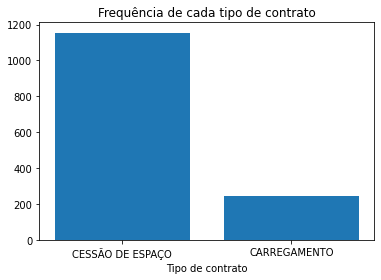

In [61]:
contagem = cntrt_dist['TIPO DE CONTRATO'].value_counts().values
categoria = cntrt_dist['TIPO DE CONTRATO'].value_counts().index
plt.bar(categoria, contagem)
plt.xlabel("Tipo de contrato")
plt.title("Frequência de cada tipo de contrato")
plt.show();

Ou seja, os contratos de cessão de espaço (f=1154) são muito mais frequentes, quase 5 vezes mais frequentes que os contratos de carregamento (f=244).

### Volume total
Vamos entender agora a distribuição de volume total firmado em cada contrato.

É interessante notar que as grandezas são diferentes para cada contrato. No **contrato de carregamento**, o volume apresentado se refere à quantidade mensal acordada que o cedente pode retirar (pode "carregar") na instalação do cessionário. Por outro lado, o **contrato de cessão de espaço** prevê o volume de capacidade de armazenamento de sua instalação que o cedente separa para uso pelo cessionário. O cessionário poderia movimentar muito mais que isso todo mês, a depender do "giro" que imprime a essa tancagem, ou seja, o número equivalente de vezes que enche e esvazia essa tancagem durante um mês.

Primeiro, vamos observar a distribuição do volume total, independente do tipo de contrato.

In [62]:
cntrt_dist['VOLUME (m³)'].describe()

count     1398.000000
mean      3375.867904
std       7515.621871
min          5.000000
25%        200.000000
50%        750.000000
75%       2735.000000
max      98448.000000
Name: VOLUME (m³), dtype: float64

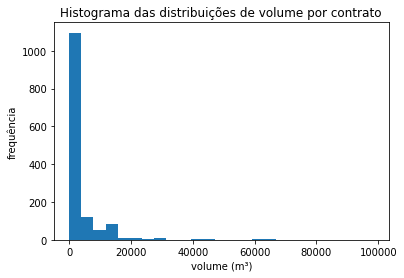

In [63]:
plt.hist(cntrt_dist['VOLUME (m³)'], bins=25) 
plt.ylabel('frequência')
plt.xlabel('volume (m³)')
plt.title('Histograma das distribuições de volume por contrato');

Podemos observar que a distribuição de contratos se concentra bastante nos contratos de volume menor. Metade da distribuição é representada por contratos até 750 m³. Na outra ponta, o contrato de maior volume tem mais de 98 mil m³. Esse contrato é evidenciado a seguir:

In [64]:
cntrt_dist[cntrt_dist['VOLUME (m³)']==cntrt_dist['VOLUME (m³)'].max()].transpose()

,546
CNPJ,34.274.233/0001-02
Razão Social,PETROBRAS DISTRIBUIDORA S.A.
Qualificação da Cessionária,DISTRIBUIDOR DE COMBUSTÍVEIS
Cep,2.02111e+07
Endereço da Matriz,RUA CORREIA VASQUES
Número,250
Bairro,CIDADE NOVA
Complemento,NaN
Município,RIO DE JANEIRO
UF,RJ


Agora vamos analisar como o volume total do contrato se relaciona com os tipos de contratos.


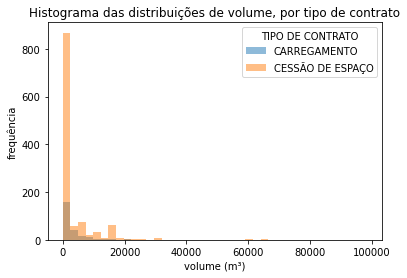

In [65]:
volume_tipo = cntrt_dist.pivot(
    index='chave_cntrt',
    columns='TIPO DE CONTRATO',
    values='VOLUME (m³)'
    )

volume_tipo.plot.hist(alpha=0.5, bins=40)
plt.ylabel('frequência')
plt.xlabel('volume (m³)')
plt.title('Histograma das distribuições de volume, por tipo de contrato');

In [66]:
volume_tipo.describe()

TIPO DE CONTRATO,CARREGAMENTO,CESSÃO DE ESPAÇO
count,244.000000,1154.000000
mean,3605.077869,3327.404099
std,8534.416634,7285.183479
min,95.000000,5.000000
25%,587.500000,150.000000
50%,1500.000000,697.500000
75%,3151.250000,2409.750000
max,98448.000000,68000.000000


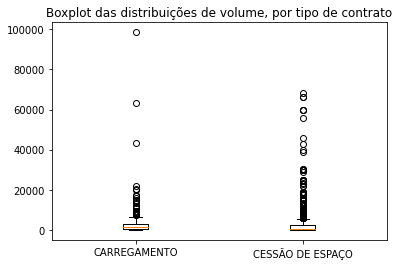

In [67]:
volume_carreg = volume_tipo['CARREGAMENTO'].dropna().tolist()
volume_cessao = volume_tipo['CESSÃO DE ESPAÇO'].dropna().tolist()

data=np.array([volume_carreg, volume_cessao], dtype='object')

fig, ax = plt.subplots()
ax.set_title('Boxplot das distribuições de volume, por tipo de contrato')
ax.boxplot(data)
ax.set_xticklabels(volume_tipo.columns.tolist())
plt.show();

A distribuição de volumes dos contratos de carregamento é levemente mais deslocada para a direita que a distribuição dos contratos de cessão de espaço. A primeira tem média de  3.605 m³ e mediana de 1.500 m³, ao passo que a segunda tem média de 3.327 m³ e mediana de 697,5 m³.

O gráfico de boxplot mostra como há muitos contratos com volumes tão grandes que se poderia considerar *outliers*, pois estão muito afastados (a mais de 1,5 vezer o intervalo interquartílico, IQR) dos valores compreendidos até o terceiro quartil.

### Produto

Vamos buscar identificar quais produtos aparecem mais frequentemente nos contratos, e quais deles representam maior volume.

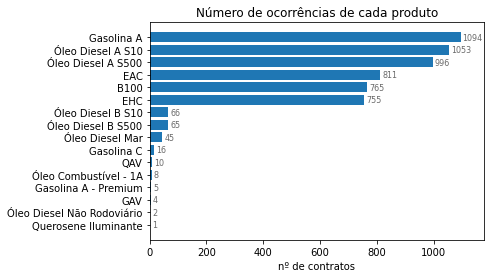

In [68]:
contagem = cntrt_produto['produto'].value_counts().values
categoria = cntrt_produto['produto'].value_counts().index

y_pos = np.arange(len(categoria)) #distribuição das categorias pelo eixo

fig2, ax2 = plt.subplots()

hbars = ax2.barh(y_pos, contagem, align='center')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(categoria)
ax2.invert_yaxis()  # inverte a ordem das barras
ax2.set_xlabel('nº de contratos')
ax2.set_title('Número de ocorrências de cada produto')

# inclui rótulos de dados com customização e expande margem para caber
#bar_label não disponível no matplotlib 3.2.2
ax2.bar_label(hbars, labels=contagem,
             padding=2, color='dimgray', fontsize=8)
ax2.set_xlim(right=(ax2.get_xlim()[1]*1.025))

plt.show()


Observa-se que a Gasolina A é o produto que aparece em mais contratos, num total de 1094 dos 1398 contratos, sendo seguida pelo óleo diesel A S10 e o óleo diesel A S500.

Os seis primeiros produtos são os principais combustíveis comercializados pelos produtores aos distribuidores, e são armazenados principalmente nesse formato. Os combustíveis fósseis (gasolina A e óleo diesel A) normalmente são misturados aos biocombustíveis (etanol anidro combustível - EAC - e biodiesel - B100) na saída da instalação de armazenamento, no momento do carregamento do caminhão tanque. Assim, as características de negócio explicam o comportamento observado nos dados.

Vamos observar também como o volume se distribui entre os diversos produtos

In [69]:
matriz_produto = cntrt_produto.pivot(
    index='chave_cntrt',
    columns='produto',
    values='qtd_produto'
    )

matriz_produto.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
produto,,,,,,,,
B100,765.0,95.783912,373.770311,0.500,10.00,30.0,70.00,5000.00
EAC,811.0,273.838557,1209.188983,2.000,20.00,60.0,150.00,15000.00
EHC,755.0,223.786442,944.676490,2.000,30.00,50.0,127.50,16485.59
GAV,4.0,685.000000,625.752880,200.000,350.00,470.0,805.00,1600.00
Gasolina A,1094.0,1359.542249,2465.184665,4.000,50.00,250.0,1900.00,21656.00
Gasolina A - Premium,5.0,2068.000000,4434.260931,50.000,50.00,120.0,120.00,10000.00
Gasolina C,16.0,139.382812,148.499421,17.125,45.00,114.0,150.00,600.00
QAV,10.0,2154.200000,2918.061830,200.000,325.00,474.0,3920.50,8500.00
Querosene Iluminante,1.0,30.000000,NaN,30.000,30.00,30.0,30.00,30.00


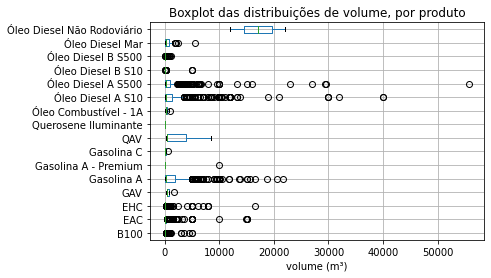

In [70]:
matriz_produto.boxplot(vert=False)
plt.title('Boxplot das distribuições de volume, por produto')
plt.xlabel('volume (m³)')
#plt.xlim(-100,5000)
plt.show();

É possível observar que, para todos os produtos à exceção do Óleo diesel não rodoviário, a distribuição se concentra em valores mais baixos (distribuições deslocadas à esquerda). Para todas esses outros, a mediana é inferior a 500 m³.

### Empresas envolvidas

Um aspecto muito importante na regulação é o fomento à concorrência no setor. Entender como as empresas se relacionam contratualmente pode fornecer *insights* sobre as estratégias concorrenciais presentes nesse mercado.
Vamos analisar quais são as principais empresas cedentes e cessionárias nessa base de dados, tanto de acordo com o número de contratos quanto em relação ao volume envolvido.

#### Cedentes

O cedente é o titular da infraestrutura, e que a cede parcial ou totalmente para outra empresa, a cessionária.

Vamos primeiro entender quantos cedentes distintos há na base de dados.

In [71]:
cntrt_dist['RAIZ DO CNPJ DA CEDENTE'].nunique()

103

São 103 empresas cedentes distintas.
Cabe lembrar que o cedente pode ser um distribuidor, que possui uma instalação de base de distribuição, ou outro tipo de empresa, como um operador de terminal ou mesmo um produtor de combustíveis fósseis ou de biocombustíveis.

##### Qualificação

Vamos agora entender como as cedentes se distribuem em relação à sua qualificação.

In [72]:
cedentes = cntrt_dist.loc[:,[
    'RAZÃO SOCIAL DA CEDENTE',
    'RAIZ DO CNPJ DA CEDENTE',
    'Qualificação do Cedente'
]].drop_duplicates(ignore_index=True)

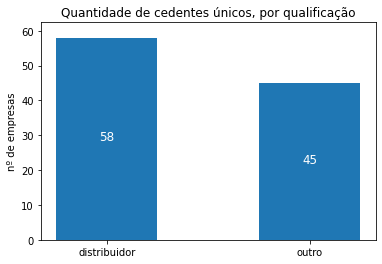

In [73]:
contagem = cedentes['Qualificação do Cedente'].value_counts().values
categoria = cedentes['Qualificação do Cedente'].value_counts().index

x_pos = np.arange(len(categoria)) #distribuição das categorias pelo eixo
largura = 0.5

fig3, ax3 = plt.subplots()

bars = ax3.bar( x_pos, contagem, width=largura, align='center')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(categoria)
ax3.set_ylabel('nº de empresas')
ax3.set_title('Quantidade de cedentes únicos, por qualificação')

# inclui rótulos de dados com customização e expande margem para caber
ax3.bar_label(bars, labels=contagem,
             padding=2, color='w', fontsize=12, label_type = 'center')
ax3.set_ylim(top=(ax3.get_ylim()[1]*1.025))

plt.show()

Dentre os 103 cedentes, 58 (56,3%) são distribuidores e os 45 restantes (43,7%) são de outra qualificação.
Esses 58 distribuidores representam 37% dos 159 distribuidores autorizados pela ANP (o número total de distribuidores foi apresentado na seção de coleta de dados, quando importamos o dataset de distribuidores).

Com isso, se observa que nem todos os distribuidores cedem suas instalações para terceiros, sendo essa uma prática realizada por menos de 2/5 deles.

Vamos entender agora como essas qualificações se distribuem em relação ao número total de contratos e o volume total contratado.

In [74]:
volume_qualif_cedente = cntrt_dist.pivot(
    index='chave_cntrt',
    columns='Qualificação do Cedente',
    values='VOLUME (m³)'
    )

In [75]:
volume_qualif_cedente.describe()

Qualificação do Cedente,distribuidor,outro
count,548.000000,850.000000
mean,724.227117,5085.396318
std,2046.044158,9098.455821
min,14.000000,5.000000
25%,90.000000,360.000000
50%,348.000000,1500.000000
75%,751.000000,6000.000000
max,42800.000000,98448.000000


In [76]:
cntrt_dist['Qualificação do Cedente'].value_counts()

outro           850
distribuidor    548
Name: Qualificação do Cedente, dtype: int64

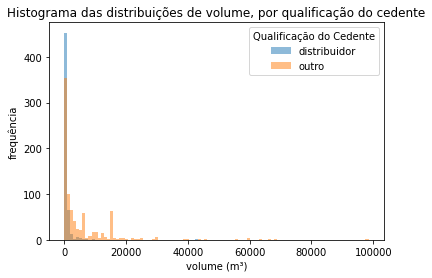

In [77]:
volume_qualif_cedente.plot.hist(alpha=0.5, bins=100)
plt.ylabel('frequência')
plt.xlabel('volume (m³)')
plt.title('Histograma das distribuições de volume, por qualificação do cedente');

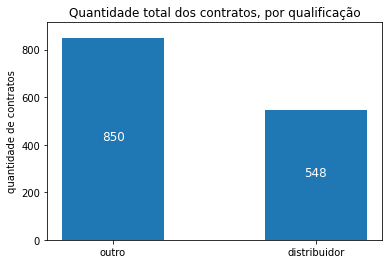

In [78]:
contagem = cntrt_dist['Qualificação do Cedente'].value_counts().values
categoria = cntrt_dist['Qualificação do Cedente'].value_counts().index

x_pos = np.arange(len(categoria)) #distribuição das categorias pelo eixo
largura = 0.5

fig3, ax3 = plt.subplots()

bars = ax3.bar(x_pos, contagem, width=largura, align='center')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(categoria)
ax3.set_ylabel('quantidade de contratos')
ax3.set_title('Quantidade total dos contratos, por qualificação')

# inclui rótulos de dados com customização e expande margem para caber
ax3.bar_label(bars, labels=contagem,
             padding=2, color='w', fontsize=12, label_type = 'center')
ax3.set_ylim(top=(ax3.get_ylim()[1]*1.025))

plt.show()

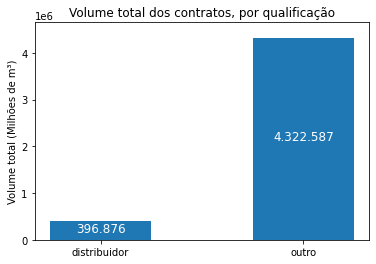

In [79]:
quantidade = volume_qualif_cedente.sum()
rotulo_quantidade = quantidade.apply(
    lambda x: "{:_.0f}".format(x).replace('_', '.')
    ).values
categoria = volume_qualif_cedente.sum().index

x_pos = np.arange(len(categoria)) #distribuição das categorias pelo eixo
largura = 0.5

fig4, ax4 = plt.subplots()

bars = ax4.bar(x_pos, quantidade, width=largura, align='center')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(categoria)
ax4.set_ylabel('Volume total (Milhões de m³)')
ax4.set_title('Volume total dos contratos, por qualificação')

# inclui rótulos de dados com customização e expande margem para caber
ax4.bar_label(bars, labels=rotulo_quantidade,
             padding=2, color='w', fontsize=12, label_type = 'center')
ax4.set_ylim(top=(ax4.get_ylim()[1]*1.025))

plt.show()

Do total de 1398 contratos, 548 (39,2%) foram firmados com um cedente distribuidor, enquanto 850 (60,8%) foram firmados com outros cedentes.

Observamos ainda que a média de volumes dos contratos firmados entre distribuidores é menor que a média de contratos com cedentes de outras qualificações.
Isso faz com que o volume total contratado com outras qualificações, mais de 4,3 milhões de m³, seja significativamente maior que o total contratado com distribuidores, que se aproxima de 0,4 milhões de m³.

Com efeito, do conhecimento do negócio sabemos que as instalações de terminais têm capacidade de  armazenamento geralmente superior às instalações dos distribuidores, em especial os terminais aquaviários, que têm que suportar os grandes lotes relacionados ao modo de transporte aquaviário. Além disso, o próprio modelo de negócio dos terminais é a prestação de serviço de movimentação e armazenamento de produtos para terceiros. 

##### Empresas

Vamos agora identificar as empresas mais significativas no universo de cedentes.

In [80]:
#lista com 10 cedentes com maior número de contratos
top_cedentes = cntrt_dist['RAZÃO SOCIAL DA CEDENTE'].value_counts().nlargest(10)

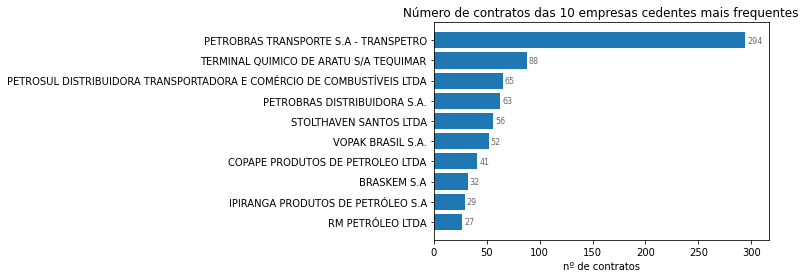

In [81]:
contagem = top_cedentes.values
categoria = top_cedentes.index

y_pos = np.arange(len(categoria)) #distribuição das categorias pelo eixo

fig5, ax5 = plt.subplots()

hbars = ax5.barh(y_pos, contagem, align='center')
ax5.set_yticks(y_pos)
ax5.set_yticklabels(categoria)
ax5.invert_yaxis()  # inverte a ordem das barras
ax5.set_xlabel('nº de contratos')
ax5.set_title('Número de contratos das 10 empresas cedentes mais frequentes')

# inclui rótulos de dados com customização e expande margem para caber
ax5.bar_label(hbars, labels=contagem,
             padding=2, color='dimgray', fontsize=8)
ax5.set_xlim(right=(ax5.get_xlim()[1]*1.025))

plt.show()

A cedente mais frequente é a empresa TRANSPETRO, que é o braço de logística da PETROBRAS, empresa que por muito tempo deteve o monopólio da produção e refino de petróleo no Brasil. A TRANSPETRO detém larga fatia da capacidade de armazenamento em terminais do Brasil e aparece em 294 contratos como cedente.

Na lista dos 10 mais frequentes há operadores de terminais, como TEQUIMAR, STOLTHAVEN, VOPAK, COPAPE e BRASKEM, bem como distribuidoras, como PETROSUL, PETROBRAS DISTRIBUIDORA (BR), IPIRANGA e RM.

Vamos entender agora como se dá a distribuição de volumes dos contratos entre as maiores empresas.

In [82]:
#lista com 10 cedentes com maior volume contratado
top_cedentes_vol = \
   cntrt_dist.groupby(by=['RAZÃO SOCIAL DA CEDENTE']).sum() \
   ['VOLUME (m³)'].nlargest(10)

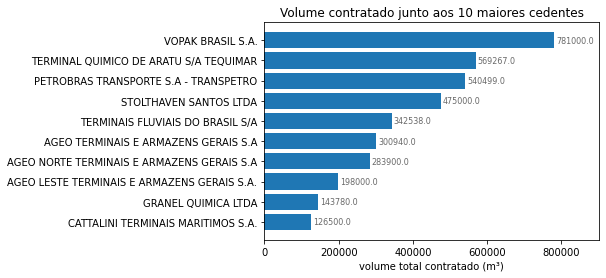

In [83]:
contagem = top_cedentes_vol.values
categoria = top_cedentes_vol.index

y_pos = np.arange(len(categoria)) #distribuição das categorias pelo eixo

fig6, ax6 = plt.subplots()

hbars = ax6.barh(y_pos, contagem, align='center')
ax6.set_yticks(y_pos)
ax6.set_yticklabels(categoria)
ax6.invert_yaxis()  # inverte a ordem das barras
ax6.set_xlabel('volume total contratado (m³)')
ax6.set_title('Volume contratado junto aos 10 maiores cedentes')

# inclui rótulos de dados com customização e expande margem para caber
ax6.bar_label(hbars, labels=contagem,
             padding=2, color='dimgray', fontsize=8)
ax6.set_xlim(right=(ax6.get_xlim()[1]*1.1))

plt.show()

A cedente com maior volume contratado é a VOPAK, uma multinacional sediada nos Países Baixos e que opera terminais aquaviários no Brasil. 

A TRANSPETRO, apesar de  ser a empresa mais frequente, aparece apenas em terceiro lugar quando se compara os volumes totais contratados com distribuidores.

Interessante notar que, nessa lista, todas as 10 primeiras posições são ocupadas por operadores de terminais.

#### Cessionários

O cessionário é aquele que contrata, parcial ou totalmente, espaço ou capacidade de instalação de outra empresa, para seu uso.

Vamos seguir um roteiro semelhante à análise dos cedentes. A principal diferença, entretanto, é que não é necessário verificar a qualificação dos cessionários. Nas etapas anteriores já separamos apenas contratos firmados com distribuidores com autorização vigente.

Vamos então iniciar verificando quantos cessionários distintos há na base de dados.

In [84]:
cntrt_dist['RAIZ DO CNPJ DA CESSIONÁRIA'].nunique()

130

São 130 distribuidoras distintas no papel de cessionária, ou seja, 82% das 159 distribuidoras.
Vamos entender como esses distribuidores se dividem entre os diferentes tipos de cedentes.

In [85]:
cntrt_dist.pivot_table(values='RAIZ DO CNPJ DA CESSIONÁRIA',
                       index='Qualificação do Cedente',
                       aggfunc=lambda x: len(x.unique()))

,RAIZ DO CNPJ DA CESSIONÁRIA
Qualificação do Cedente,
distribuidor,110
outro,110


Há 110 distribuidores distintos (69% do total de distribuidores) como cessionário de outro distribuidor. Coincidentemente, há o mesmo número de cessionários distintos junto a cedentes de outras qualificações

Vamos verificar agora as principais distribuidoras desse conjunto. Primeiro, as com maior número de contratos.

In [86]:
#lista com 10 cessionários com maior número de contratos
top_cessionarios = cntrt_dist['RAZÃO SOCIAL DA CESSIONÁRIA'].value_counts().nlargest(10)

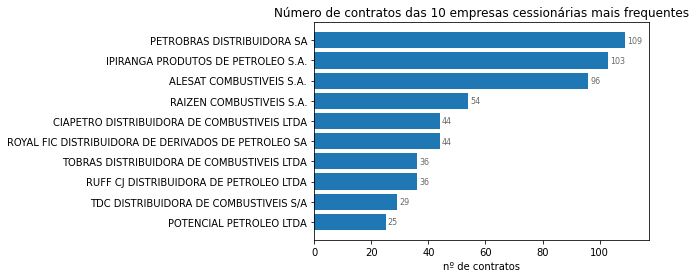

In [87]:
contagem = top_cessionarios.values
categoria = top_cessionarios.index

y_pos = np.arange(len(categoria)) #distribuição das categorias pelo eixo

fig5, ax5 = plt.subplots()

hbars = ax5.barh(y_pos, contagem, align='center')
ax5.set_yticks(y_pos)
ax5.set_yticklabels(categoria)
ax5.invert_yaxis()  # inverte a ordem das barras
ax5.set_xlabel('nº de contratos')
ax5.set_title('Número de contratos das 10 empresas cessionárias mais frequentes')

# inclui rótulos de dados com customização e expande margem para caber
ax5.bar_label(hbars, labels=contagem,
             padding=2, color='dimgray', fontsize=8)
ax5.set_xlim(right=(ax5.get_xlim()[1]*1.025))

plt.show()

A cessionária mais frequente é a PETROBRAS DISTRIBUIDORA (BR), em 109 contratos, seguida pela IPIRANGA, com 103, e pela ALESAT, com 96. É interessante lembrar que a BR e a IPIRANGA apareceram também na lista dos 10 cedentes com mais contratos.

Esse parece ser um comportamento frequente, em que um distribuidor ora cede espaço, ora utiliza espaço de outros distribuidores. Esse comportamento de cooperação entre distribuidores, que teoricamente seriam concorrentes, abre espaço para uma investigação mais detalhada.

Vamos entender agora como se dá a distribuição de volumes dos contratos entre as maiores empresas.

In [88]:
#lista com 10 cessionários com maior volume contratado
top_cessionarios_vol = \
   cntrt_dist.groupby(by=['RAZÃO SOCIAL DA CESSIONÁRIA']).sum() \
   ['VOLUME (m³)'].nlargest(10)

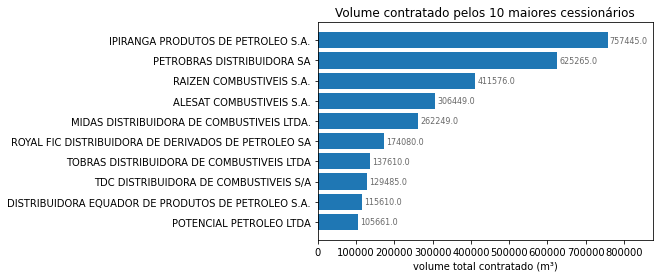

In [89]:
contagem = top_cessionarios_vol.values
categoria = top_cessionarios_vol.index

y_pos = np.arange(len(categoria)) #distribuição das categorias pelo eixo

fig7, ax7 = plt.subplots()

hbars = ax7.barh(y_pos, contagem, align='center')
ax7.set_yticks(y_pos)
ax7.set_yticklabels(categoria)
ax7.invert_yaxis()  # inverte a ordem das barras
ax7.set_xlabel('volume total contratado (m³)')
ax7.set_title('Volume contratado pelos 10 maiores cessionários')

# inclui rótulos de dados com customização e expande margem para caber
ax7.bar_label(hbars, labels=contagem,
             padding=2, color='dimgray', fontsize=8)
ax7.set_xlim(right=(ax7.get_xlim()[1]*1.1))

plt.show()

Nessa lista, a IPIRANGA ocupa a primeira posição com o maior somatório de volumes de contratos, seguida pela BR e RAIZEN.

### Cendentes x Cessionários

Seguindo na trilha de analisar as relações cruzadas entre cedentes e cessionários, vamos montar um mapa de calor que represente as relações entre essas empresas.

Para estudar as relações entre potenciais concorrentes, temos de filtrar apenas os cedentes que são qualificados como distribuidores.

Isso vai nos deixar com uma matriz que tem, em um eixo, 58 distribuidores cedentes e, no outro eixo, 130 cessionários. Essa matriz é povoada por 548 contratos firmados entre essas empresas.

In [90]:
#definindo as colunas de interesse
cols=['RAZÃO SOCIAL DA CEDENTE','RAZÃO SOCIAL DA CESSIONÁRIA']

#filtrando apenas pelos contratos em que o cedente é um distribuidor
feicao = cntrt_dist[cntrt_dist['Qualificação do Cedente']=="distribuidor"]
feicao = feicao.loc[:,cols] #selecionando as colunas de interesse
feicao['qtd'] = 1  #nova coluna para contagem

#cria um dataframe com a contagem de contratos, com dois índices aninhados
feicao_anin = feicao.groupby(by=cols).count()

In [91]:
#mostrar na tela as dez relações com mais contratos
feicao_anin['qtd'].sort_values(ascending=False).head(10)

RAZÃO SOCIAL DA CEDENTE               RAZÃO SOCIAL DA CESSIONÁRIA       
IPIRANGA PRODUTOS DE PETRÓLEO S.A     PETROBRAS DISTRIBUIDORA SA            19
PETROBRAS DISTRIBUIDORA S.A.          IPIRANGA PRODUTOS DE PETROLEO S.A.    14
                                      ALESAT COMBUSTIVEIS S.A.               9
                                      RAIZEN COMBUSTIVEIS S.A.               9
RAIZEN COMBUSTÍVEIS S.A.              RAIZEN MIME COMBUSTIVEIS S.A.          6
IDAZA DISTRIBUIDORA DE PETRÓLEO LTDA  PETROBRAS DISTRIBUIDORA SA             5
RAIZEN COMBUSTÍVEIS S.A.              PETROBRAS DISTRIBUIDORA SA             5
IPIRANGA PRODUTOS DE PETRÓLEO S.A     ALESAT COMBUSTIVEIS S.A.               5
PETRÓLEO SABBÁ S.A.                   RAIZEN COMBUSTIVEIS S.A.               4
IDAZA DISTRIBUIDORA DE PETRÓLEO LTDA  ALESAT COMBUSTIVEIS S.A.               4
Name: qtd, dtype: int64

Do trecho de dataframe apresentado acima, com as relações entre cedente e cessionário com maior número de contratos, é possível notar que a relação entre IPIRANGA (como cessionária) e BR (como cedente) é a com maior número de contratos, 19.

Logo na sequência, essas empresas se invertem em posição. A cedente BR e a cessionária IPIRANGA têm 14 contratos, sendo a segunda relação mais frequente.

In [92]:
feicao_arr = feicao_anin.to_xarray().to_array()[0]

feicao_arr

<xarray.DataArray (RAZÃO SOCIAL DA CEDENTE: 58, RAZÃO SOCIAL DA CESSIONÁRIA: 110)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * RAZÃO SOCIAL DA CEDENTE      (RAZÃO SOCIAL DA CEDENTE) object '76 OIL DIS...
  * RAZÃO SOCIAL DA CESSIONÁRIA  (RAZÃO SOCIAL DA CESSIONÁRIA) object '76 OIL...
    variable                     <U3 'qtd'

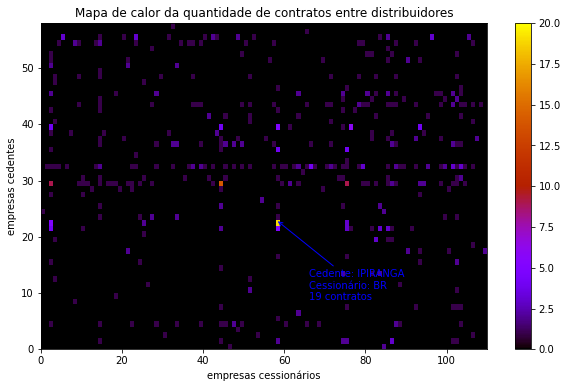

In [93]:
fig, ax0 = plt.subplots(figsize=(10,6))

#gráfico pcolormesh, um grid de cores
#a matriz feicao_arr terá os valores nulos (nan) substituídos por zero
c = ax0.pcolormesh(feicao_arr.fillna(0), cmap='gnuplot', vmax=20)
ax0.set_title('Mapa de calor da quantidade de contratos entre distribuidores')
ax0.set_xlabel('empresas cessionários')
ax0.set_ylabel('empresas cedentes')

#cria uma anotação com seta num ponto de interesse
ax0.annotate("Cedente: IPIRANGA \nCessionário: BR \n19 contratos",
            xy=(58, 23), xycoords='data',
            xytext=(0.6, 0.15), textcoords='axes fraction',
            color='b',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3",
                            color='b'),
            )

#legenda de cores
fig.colorbar(c, ax=ax0)

plt.show();

O mapa de calor elenca os distribuidores cedentes no eixo y e os cessionários no eixo x. 

Cada pequeno retângulo no grid representa os contratos entre um determinado cedente e um determinado cessionário. Os retângulos são coloridos de acordo com a quantidade de contratos entre aqueles cedente e cessionário, de preto, para nenhum contrato, até amarelo, no máximo de contratos.

No gráfico está destacado, por volta do cedente nº 22 e do cessionário nº 58, a relação entre IPIRANGA e BR, que têm 19 contratos.

É possível observar também a linha do cedente nº 29, que é a BR enquanto cedente. Nessa linha, há três retângulos vermelhos, que são suas relações com os cessionários IPIRANGA, ALESAT e RAIZEN.

Mais acima, por volta do cedente nº 32, se destaca uma linha horizontal mais povoada, que representa o cedente PETROSUL, o segundo distribuidor cedente com mais contratos, firmados com uma diversidade de cessionários.

## Criação de Modelos de Machine Learning

Vimos na seção anterior que é comum que um par de distribuidores se alterne no papel de cedente e de cessionário. Isso pode dar a impressão de um acordo de *quid pro quo*, ou seja, um acordo de compensação do tipo "eu cedo espaço para você na minha instalação se você me ceder espaço na sua instalação". 

Esse tipo de comportamento pode levantar suspeitas quanto ao padrão competitivo dos participantes, já que pode deixar de fora outros interessados em utilizar uma mesma infraestrutura. No limite, pode configurar em crime contra a ordem econômica. A Lei nº 8137, de 1990, considera como crime contra a ordem econômica o acordo entre empresas com objetivo de fixar artificialmente os preços ou quantidades dos produtos e serviços, de controlar um mercado, limitando a concorrência.

A mineração de padrões frequentes pode ser utilizada para identificar, numa grande base de dados, a ocorrência de grupos de empresas que frequentemente compartilham a mesma infraestrutura.

Nessa seção, vamos aplicar os algoritmos de identificação de conjuntos de itens frequentes para fazer essa identificação. Será utilizada a biblioteca ```mlxtend``` do python.

O problema de mineração de conjuntos de itens frequentes precisa, como dados de entrada, de:


1.   Um conjunto de itens
2.   Uma tabela de transações sobre esses itens
3.   Um número *supp*<sub>min</sub>, tal que 0 < *supp*<sub>min</sub> < 1, o **suporte mínimo**

Tendo isso em vista, podemos identificar o conjunto de itens para o nosso problema como o conjunto de *distribuidores*.
Um pouco menos trivial é a tabela de transações. O dataset de contratos, da forma como está, é pouco atrativo para essa análise. Em primeiro lugar, esse dataset de contratos tem apenas cedente e cessionário em cada contrato (ou transação). Segundo porque parte dos cedentes não é distribuidor, e nossa análise está focada nas relações entre distribuidores; os terminais, por exemplo, normalmente têm um modelo de negócio baseado na prestação de serviço para diversos agentes e não na comercialização de produtos, de modo que um operador de terminal não teria intenção de ser compensado com espaço cedido a ele em uma base de distribuição.

Assim, muito mais interessante será partir de uma tabela onde cada transação seja referente a uma *instalação de distribuidora*. Os itens de cada transação serão, além da própria distribuidora cedente, todas as outras distribuidoras que são cessionárias naquela instalação.

Como resultado, vamos identificar:
1.   Aquelas distribuidoras que mais frequentemente aparecem juntas em uma mesma instalação, ou seja, que têm maior suporte *supp*, superior ao *supp*<sub>min</sub>; e
2.   Um conjunto de associações, ou regras de associação, com confiança superior a um mínimo definido, que identificarão possíveis padrões de interesse nesses dados.

### Tratamento dos dados para aplicar o modelo

Como explicado, vamos montar a tabela de instalações (transações), e seus usuários (itens da transação).
Cada instalação é identificada, no dataset `cntrt_dist`, a partir do campo `'CNPJ DA CEDENTE'`.

Tanto cedentes quanto cessionários serão considerados `USUARIO` da instalação.

A biblioteca `mlxtend` exige que a tabela de transações seja, na verdade, uma lista que agrupe listas de itens, num formato como a seguir:

```
tab_trans = [['Apple', 'Beer', 'Rice', 'Chicken'],
             ['Apple', 'Beer', 'Rice'],
             ['Apple', 'Bananas'],
             ['Milk', 'Beer', 'Rice', 'Chicken']]
```

In [94]:
#novo slice do dataset principal apenas com cedentes distribuidores
cntrt_dist_only = cntrt_dist[cntrt_dist['Qualificação do Cedente']=='distribuidor']

In [95]:
#número de instalações únicas
cntrt_dist_only['CNPJ DA CEDENTE'].nunique()

143

In [96]:
#cria um dataset auxiliar apenas com CNPJ e Razão social dos cendentes
inst_ced_ced = cntrt_dist_only.loc[:,{
    'CNPJ DA CEDENTE',
    'RAZÃO SOCIAL DA CEDENTE'
    }].drop_duplicates()

#O cedente também é usuário da infraestrutura.
#Usaremos o nome USUARIO para a coluna com sua razão social. 
inst_ced_ced.rename(
    columns={'RAZÃO SOCIAL DA CEDENTE':'USUARIO'},
    inplace=True
    )

#cria um dataset auxiliar> CNPJ da instalação e Razão social dos cessionários
#'Razão Social' contem a razão social padronizada, do dataset distribuidores
inst_ced_cess = cntrt_dist_only.loc[:,{
    'CNPJ DA CEDENTE',
    'Razão Social'    
    }]

#Usaremos o nome USUARIO para a coluna com razão social. 
inst_ced_cess.rename(
    columns={'Razão Social':'USUARIO'},
    inplace=True
    )

#juntando os dois datasets auxiliares.
#exclui duplicadas (um mesmo cedente e cessionário podem assinar mais de um contrato)
inst_usuario = inst_ced_cess.append(inst_ced_ced, ignore_index=True).drop_duplicates()

inst_usuario.describe()

,USUARIO,CNPJ DA CEDENTE
count,633,633
unique,123,143
top,PETROBRAS DISTRIBUIDORA S.A.,00.175.884/0002-04
freq,60,33


In [97]:
#cria a lista de transações no formato requerido para iniciar o uso do mlxtend
tab_trans = inst_usuario.groupby('CNPJ DA CEDENTE')['USUARIO'].apply(list).tolist()

Por último, antes de aplicar propriamente os algoritmos de mineração de conjuntos de itens frequentes, vamos tratar a tabela de transações com as ferramentas de pré-processamento fornecidas pela biblioteca `mlxtend`. 

O resultado, uma lista de listas, é um objeto semelhante a uma tabela, em que cada coluna é um usuário possível e cada linha é uma instalação. A tabela é preenchida com `True` quando aquele distribuidor é usuário daquela instalação, ou `False` caso contrário.

In [98]:
te = TransactionEncoder()
te_ary = te.fit(tab_trans).transform(tab_trans)
te_ary

array([[False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False]])

Por fim, vamos recompor esses dados para um dataframe do `pandas`, recuperando os nomes das colunas com a propriedade `self.columns_`


In [99]:
df_ml = pd.DataFrame(te_ary, columns=te.columns_)
df_ml

,76 OIL DISTRIBUIDORA DE COMBUSTÍVEIS S/A,AGILE LOGISTICA E DISTRIBUIÇÃO DE COMBUSTÍVEIS LTDA,ALESAT COMBUSTÍVEIS S. A.,ALL DISTRIBUIDORA DE COMBUSTÍVEIS EIRELI,ALPES DISTRIBUIDORA DE PETRÓLEO LTDA.,AMERICANOIL DISTRIBUIDORA DE DERIVADOS DE PETRÓLEO EIRELI,ARAGUAIA DISTRIBUIDORA DE COMBUSTÍVEIS S.A,ART PETRO DISTRIBUIDORA DE COMBUSTÍVEIS LTDA.,ASPEN DISTRIBUIDORA DE COMBUSTÍVEIS LTDA,ASTER PETRÓLEO LTDA.,ATEM' S DISTRIBUIDORA DE PETRÓLEO S.A.,ATLANTA DISTRIBUIDORA DE PETRÓLEO LTDA.,ATLÂNTICA PRODUTOS DE PETRÓLEO LTDA.,BIOPETRÓLEO DO BRASIL DISTRIBUIDORA DE COMBUSTÍVEIS LTDA,CARBOPETRO DISTRIBUIDORA DE PETRÓLEO LTDA.,CIAPETRO DISTRIBUIDORA DE COMBUSTÍVEIS LTDA,COMÉRCIO DE DERIVADOS DE PETRÓLEO ISABELLA LTDA.,COPERCANA DISTRIBUIDORA DE COMBUSTIVEIS LTDA,CRUZ DE MALTA DISTRIBUIDORA DE PETRÓLEO LTDA.,DANPETRO DISTRIBUIDORA DE PETRÓLEO S.A.,DIBRAPE DISTRIBUIDORA BRASILEIRA DE PETRÓLEO LTDA.,DIRECIONAL DISTRIBUIDORA DE DERIVADOS DE PETRÓLEO LTDA.,DISLUB COMBUSTÍVEIS S/A,DISTRIBUIDORA DE COMBUSTIVEIS MASUT LTDA,DISTRIBUIDORA DE COMBUSTÍVEIS SAARA S.A.,DISTRIBUIDORA DE COMBUSTÍVEL TORRÃO LTDA.,DISTRIBUIDORA DE PRODUTOS DE PETRÓLEO CHARRUA LTDA,DISTRIBUIDORA EQUADOR DE PRODUTOS DE PETRÓLEO LTDA.,DISTRIBUIDORA MONTEPETRO DE PETRÓLEO LTDA.,DISTRIBUIDORA RIO BRANCO DE PETRÓLEO LTDA.,DISTRIBUIDORA TABOCÃO LTDA.,DUVALE DISTRIBUIDORA DE PETRÓLEO E ÁLCOOL LTDA.,D`MAIS DISTRIBUIDORA DE PETRÓLEO LTDA.,ECOLÓGICA DISTRIBUIDORA DE COMBUSTÍVEIS LTDA.,ESTRADA DISTRIBUIDORA DE DERIVADOS DE PETRÓLEO LTDA.,FAN - DISTRIBUIDORA DE PETRÓLEO LTDA.,FEDERAL DISTRIBUIDORA DE PETRÓLEO LTDA.,FERA LUBRIFICANTES LTDA.,FGC DISTRIBUIDORA DE COMBUSTÍVEIS LTDA.,FLAG DISTRIBUIDORA DE PETRÓLEO LTDA.,...,POTENCIAL PETRÓLEO LTDA,RAIZEN COMBUSTÍVEIS S.A.,RAIZEN MIME COMBUSTIVEIS S/A.,RAVATO DISTRIBUIDORA DE COMBUSTIVEIS LTDA.,REALCOOL DISTRIBUIDORA DE PETROLEO LTDA.,REDE SOL FUEL DISTRIBUIDORA S/A.,REDEPETRO DISTRIBUIDORA DE PETRÓLEO LTDA.,REJAILE DISTRIBUIDORA DE PETRÓLEO LTDA,RM PETRÓLEO LTDA,RODOIL DISTRIBUIDORA DE COMBUSTÍVEIS LTDA,RODOPETRO DISTRIBUIDORA DE PETRÓLEO LTDA.,ROYAL FIC DISTRIBUIDORA DE DERIVADOS DE PETRÓLEO S/A,RUFF CJ DISTRIBUIDORA DE PETRÓLEO LTDA,RUMOS DISTRIBUIDORA DE PETRÓLEO LTDA.,SADA COMBUSTÍVEIS LTDA,SETTA COMBUSTÍVEIS S/A.,SIM DISTRIBUIDORA DE COMBUSTIVEIS LTDA,SIMARELLI DISTRIBUIDORA DE DERIVADOS DE PETRÓLEO LTDA.,SMALL DISTRIBUIDORA DE DERIVADOS DE PETRÓLEO LTDA.,SP INDÚSTRIA E DISTRIBUIDORA DE PETRÓLEO LTDA,SR BRASIL PETRÓLEO LTDA.,STANG DISTRIBUIDORA DE PETRÓLEO LTDA.,STOCK DISTRIBUIDORA DE PETRÓLEO LTDA,SUL COMBUSTÍVEIS LTDA.,TAG DISTRIBUIDORA DE COMBUSTÍVEIS S/A.,TAURUS DISTRIBUIDORA DE PETRÓLEO LTDA,TDC DISTRIBUIDORA DE COMBUSTÍVEIS S/A.,TEMAPE - TERMINAIS MARÍTIMOS DE PERNAMBUCO LTDA.,TOBRAS DISTRIBUIDORA DE COMBUSTÍVEIS LTDA.,TOTAL BRASIL DISTRIBUIDORA LTDA,TOWER BRASIL PETRÓLEO LTDA.,TRANSO COMBUSTÍVEIS LTDA,TRIANGULO DISTRIBUIDORA DE PETRÓLEO LTDA,UNI COMBUSTÍVEIS LTDA,UNIBRASPE BRASILEIRA DE PETRÓLEO S/A.,VAISHIA DISTRIBUIDORA E TRANSPORTADORA DE COMBUSTIVEIS EIRELI,VETOR COMÉRCIO DE COMBUSTÍVEIS EIRELI,WALENDOWSKY DISTRIBUIDORA DE COMBUSTÍVEIS LTDA,WATT DISTRIBUIDORA BRASILEIRA DE COMBUSTÍVEIS E DERIVADOS DE PETRÓLEO LTDA,YPETRO DISTRIBUIDORA DE COMBUSTIVEIS S.A.
0,False,True,False,True,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,...,True,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False
1,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False,False,True,False

### Aplicação dos modelos de mineração de conjuntos de itens frequentes

Dois algoritmos são bastante conhecidos para mineração de itemsets frequentes: Apriori e FP-growth. Vamos inicialmente mostrar a implementação de ambos com a biblioteca `mlxtend`, o que é relativamente fácil.

Como o nosso objetivo é identificar associações entre distribuidoras, serão excluídos dos resultados os itemsets unitários, ou seja, com apenas um elemento.

Ambos os algoritmos analisados entregam o mesmo resultado em termos de itemsets frequentes com determinado suporte mínimo. A diferença entre eles está no tempo de execução, que é o que vamos demonstrar.

Para esses primeiros passos, vamos determinar um suporte mínimo arbitrário igual a 5%.

In [100]:
#definição de suporte mínimo
supp_min = 0.05

#### *Apriori*

O algoritmo *Apriori* foi o primeiro algoritmo criado para mineração de itemsets e regras de associação. Ele utiliza uma estratégia de busca em largura e passa pela base de dados diversas vezes, o que teoricamente faz dele um algoritmo mais lento que outros mais modernos.

In [101]:
inicio = timeit.default_timer()  #medição de tempo de execução: INÍCIO

#retorna dataset com o número dos itemsets e seus respectivos suportes
freq_itemsets_ap = apriori(
    df_ml,
    min_support=supp_min,
#    use_colnames=True
    )
fim = timeit.default_timer()   #medição de tempo de execução: FIM

print ('duração: %f segundos' % (fim - inicio))

duração: 0.012537 segundos


O resultado retornado é um conjunto de itemsets que tem suporte superior ao mínimo definido, como vemos a seguir. O nome dos distribuidores foi suprimido nesse primeiro momento, e estão representados apenas por um número.

Como explicado antes, serão apresentados apenas os itemsets com dois ou mais itens.

In [102]:
#inclui a coluna para medir a quantidade de elementos em cada itemset frequente
freq_itemsets_ap['length'] = freq_itemsets_ap['itemsets'].apply(lambda x: len(x))

freq_itemsets_ap[freq_itemsets_ap['length']>1].sort_values(by='support', ascending=False)

,support,itemsets,length
21,0.265734,"(48, 65)",2
23,0.139860,"(65, 84)",2
17,0.111888,"(65, 2)",2
22,0.097902,"(48, 84)",2
16,0.090909,"(48, 2)",2
18,0.076923,"(2, 84)",2
25,0.069930,"(48, 65, 2)",3
26,0.062937,"(48, 65, 84)",3
19,0.055944,"(2, 95)",2
20,0.055944,"(96, 15)",2


Com *supp*<sub>min</sub> 	&ge; 5% foram identificados 11 itemsets contendo 2 ou mais itens.

#### *FP-growth*

O algoritmo FP-growth (do inglês *Frequent Pattern Growth*) consegue diminuir o número de vezes que varre todo o banco de dados por meio de uma estratégia de busca em profundidade. Assim, espera-se que sua execução ocorra em um tempo menor que o algoritmo Apriori, dada uma mesma base de dados e o mesmo suporte mínimo.

In [103]:
inicio = timeit.default_timer()  #medição de tempo de execução: INÍCIO

#retorna dataset com o número dos itemsets e seus respectivos suportes
#método fpgrowt
freq_itemsets_fp = fpgrowth(
    df_ml,
    min_support=supp_min,
#    use_colnames=True
    )
fim = timeit.default_timer()   #medição de tempo de execução: FIM

print ('duração: %f segundos' % (fim - inicio))

duração: 0.009521 segundos


De fato, o tempo mínimo requerido foi menor.

A seguir, apresentamos o resultado de itemsets frequentes não unitários retornado pelo algoritmo FP-growth, para ressaltar que a resposta é idêntica à gerada pelo algoritmo Apriori. 

In [104]:
#inclui a coluna para medir a quantidade de elementos em cada itemset frequente
freq_itemsets_fp['length'] = freq_itemsets_fp['itemsets'].apply(lambda x: len(x))

freq_itemsets_fp[freq_itemsets_fp['length']>1].sort_values(by='support', ascending=False)

,support,itemsets,length
25,0.265734,"(48, 65)",2
18,0.139860,"(65, 84)",2
22,0.111888,"(65, 2)",2
19,0.097902,"(48, 84)",2
23,0.090909,"(48, 2)",2
21,0.076923,"(2, 84)",2
24,0.069930,"(48, 65, 2)",3
20,0.062937,"(48, 65, 84)",3
16,0.055944,"(95, 111)",2
17,0.055944,"(96, 15)",2


#### Comparação de tempo de execução

Agora vamos comparar o tempo de execução dos algoritmos Apriori e FP-growth para diversos valores de suporte, a fim de entender como esses algoritmos se comportam.

In [105]:
#lista_supp_min = range(0.01, 0.3, 0.03)

tab_ap_fp = pd.DataFrame(
    columns=['supp_min','tempo_ap','tempo_fp','num_itemsets']
    )

for i in range(1,15):
  #define o suporte mínimo
  supp_min = 0.3*i/15
  
  #Mede o tempo de execução do Apriori
  inicio_ap = timeit.default_timer()
  freq_itemsets_ap = apriori(df_ml, min_support=supp_min)
  fim_ap = timeit.default_timer()

  #Mede o tempo de execução do FP-growth
  inicio_fp = timeit.default_timer()
  freq_itemsets_fp = fpgrowth(df_ml, min_support=supp_min)
  fim_fp = timeit.default_timer()

  #Conta o número de itemsets não unitários
  num_itens = freq_itemsets_ap['itemsets'].apply(lambda x: len(x)>1).sum()

  #Alimenta do dataframe com os resultados
  tab_ap_fp.loc[i] = [supp_min]+[fim_ap-inicio_ap]+[fim_fp-inicio_fp]+[num_itens]


A tabela e o gráfico a seguir mostram o desempenho dos dois algoritmos (tempo_ap = '*Apriori*' e tempo_fp = '*FP-growth*') para cada suporte mínimo.

O suporte mínimo de 28% já não retorna nenhum itemset com dois ou mais itens.

In [106]:
tab_ap_fp

,supp_min,tempo_ap,tempo_fp,num_itemsets
1,0.02,0.044332,0.018096,1092.0
2,0.04,0.006726,0.005272,26.0
3,0.06,0.005683,0.003462,8.0
4,0.08,0.004240,0.003201,5.0
5,0.10,0.004307,0.003028,3.0
6,0.12,0.003987,0.002806,2.0
7,0.14,0.003902,0.002715,1.0
8,0.16,0.003866,0.002681,1.0
9,0.18,0.004085,0.002753,1.0
10,0.20,0.005691,0.004209,1.0


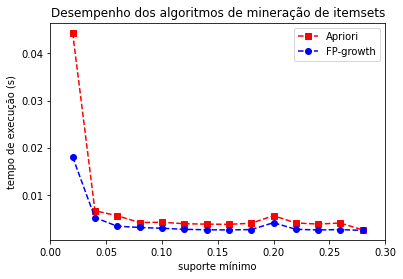

In [107]:
fig8, ax8 = plt.subplots()

#ax8.scatter(tab_ap_fp.supp_min, tab_ap_fp.tempo_ap, c='r', label='Apriori')
ax8.plot(tab_ap_fp.supp_min, tab_ap_fp.tempo_ap,'rs--', label='Apriori')
ax8.plot(tab_ap_fp.supp_min, tab_ap_fp.tempo_fp, 'bo--', label='FP-growth')
ax8.set_xlabel("suporte mínimo")
ax8.set_xlim(0,0.3)
ax8.set_ylabel("tempo de execução (s)")
ax8.legend()
ax8.set_title('Desempenho dos algoritmos de mineração de itemsets')

plt.show()

Como podemos observar, o algoritmo Apriori apresentou valores de tempo de execução mais longos que o algoritmo FP-growth. A diferença entre eles é ainda mais acentuada para valores de suporte mínimo menores, quando o número de itemsets retornados aumenta muito.

Dessa forma, fica demonstrado que o algoritmo FP-growth é mais eficiente que o algoritmo Apriori na identificação de itemsets frequentes.

### Identificação de regras de associação

A descoberta de relações implícitas entre itens frequentes de uma base de dados pode ser um importante insumo para a tomada de decisão. Além do clássico exemplo de identificação de padrões de consumo ("análise de carrinho de compras"), a mineração de regras de associação pode ser utilizada na identificação de comportamentos inidôneos por agentes econômicos, por exemplo fraudes envolvendo cartões de crédito e uso de seguros, bem como colusão em licitações públicas.

Uma regra de associação entre um itemset antecedente, {A}, e um itemset consequente, {B}, pode ser denotada por:

> {A}	&rarr; {B} 

A confiança de uma regra de associação, *conf(A&rarr;B)*, é definida como a probabilidade condicional de A, dado B.

> *conf(A&rarr;B)* &equiv; p(B|A) = p(A&cup;B)/p(A) = *supp(A,B)*/*supp(A)*

A confiança, no nosso caso, mensura a probabilidade de a distribuidora B estar incluída em uma instalação em que a distribuidora A esteja.

Outra estatística comumente utilizada para avaliar a qualidade de uma regra de associação é o *lift* (também conhecido como *coeficiente de interesse*), assim definido:
> *lift(A&rarr;B)* = *supp(A,B)* / [*supp(A)*x*supp(B)*]

 O *lift* reflete a noção estatística de independência entre duas variáveis aleatórias. Valores de *lift* iguais a 1 indicam que A e B são independentes. Por outro lado, valores de *lift* superiores a 1 indicam correlação positiva entre esses itens, ou seja, indica que A e B aparecem mais frequentemente juntos do que o esperado, de modo que a ocorrência de A tem um efeito positivo sobre a ocorrência de B.

Vamos definir valores arbitrários mínimos de suporte e confiança, de modo a selecionar um conjunto de regras de associação de maior interesse para análises futuras de associação entre os distribuidores.

>*supp*<sub>min</sub> = 4%

>*conf*<sub>min</sub> = 50%

Lembre-se que a tabela de instalações tem 143 registros. Suporte mínimo de 4% significa que aquele itemset deve estar presente em mais de (4% x 143) = 5,7 instalações, ou seja, pelo menos 6 instalações. Isso é necessário para eliminar regras casuísticas.

Já confiança superior a 50% significa que, se um distribuidor antecedente está em uma instalação presente na tabela original de contratos de cessão de espaço, significa que o outro distribuidor consequente está em mais da metade dessas instalações.

Vamos apresentar o resultado do maior para o menor lift.

In [108]:
supp_min = 0.04
conf_min = 0.5

freq_itemsets = fpgrowth(df_ml, min_support=supp_min, use_colnames=True)

regras = association_rules(freq_itemsets, 
                           metric="confidence", 
                           min_threshold=conf_min)

regras.sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
15,(RUMOS DISTRIBUIDORA DE PETRÓLEO LTDA.),(GOL COMBUSTÍVEIS S.A),0.069930,0.041958,0.041958,0.600000,14.300000,0.039024,2.395105
14,(GOL COMBUSTÍVEIS S.A),(RUMOS DISTRIBUIDORA DE PETRÓLEO LTDA.),0.041958,0.069930,0.041958,1.000000,14.300000,0.039024,inf
10,(RUMOS DISTRIBUIDORA DE PETRÓLEO LTDA.),(TOWER BRASIL PETRÓLEO LTDA.),0.069930,0.069930,0.041958,0.600000,8.580000,0.037068,2.325175
11,(TOWER BRASIL PETRÓLEO LTDA.),(RUMOS DISTRIBUIDORA DE PETRÓLEO LTDA.),0.069930,0.069930,0.041958,0.600000,8.580000,0.037068,2.325175
12,(TOBRAS DISTRIBUIDORA DE COMBUSTÍVEIS LTDA.),(TOWER BRASIL PETRÓLEO LTDA.),0.083916,0.069930,0.041958,0.500000,7.150000,0.036090,1.860140
13,(TOWER BRASIL PETRÓLEO LTDA.),(TOBRAS DISTRIBUIDORA DE COMBUSTÍVEIS LTDA.),0.069930,0.083916,0.041958,0.600000,7.150000,0.036090,2.290210
8,(TOBRAS DISTRIBUIDORA DE COMBUSTÍVEIS LTDA.),(RUMOS DISTRIBUIDORA DE PETRÓLEO LTDA.),0.083916,0.069930,0.041958,0.500000,7.150000,0.036090,1.860140
9,(RUMOS DISTRIBUIDORA DE PETRÓLEO LTDA.),(TOBRAS DISTRIBUIDORA DE COMBUSTÍVEIS LTDA.),0.069930,0.083916,0.041958,0.600000,7.150000,0.036090,2.290210
2,(TOBRAS DISTRIBUIDORA DE COMBUSTÍVEIS LTDA.),(RUFF CJ DISTRIBUIDORA DE PETRÓLEO LTDA),0.083916,0.104895,0.055944,0.666667,6.355556,0.047142,2.685315
3,(RUFF CJ DISTRIBUIDORA DE PETRÓLEO LTDA),(TOBRAS DISTRIBUIDORA DE COMBUSTÍVEIS LTDA.),0.104895,0.083916,0.055944,0.533333,6.355556,0.047142,1.963037


In [109]:
regras.shape[0]

24

Esses parâmetros de escolha nos retornaram um total de 24 (vinte e quatro) regras de associação com alto interesse. Vamos agora observar o lift desse conjunto de regras de associação.

In [110]:
print(f"O lift mínimo observado foi  {round(regras['lift'].min(),2)}")
print(f"O lift máximo observado foi  {round(regras['lift'].max(),2)}")

O lift mínimo observado foi  1.19
O lift máximo observado foi  14.3


O lift mínimo observado foi  1,19.
O lift máximo observado foi  14,3

## Interpretação e Apresentação dos Resultados

Vimos na seção de *Análise e Exploração dos Dados* que é comum os distribuidores se alternarem na posição de cedente e cessionário.

Vimos também que apenas 37% dos 159 distribuidores cedem suas instalações para terceiros. Do outro lado, 82% dos distribuidores são cessionários em alguma instalação, sendo que 69% de todos os distribuidores são cessionários de outro distribuidor.

Apesar de os maiores volumes serem contratados junto a operadores de terminais e outras qualificações, as instalações de distribuidores estão mais capilarizadas e, em alguns casos, estão em localidades estratégicas para o negócio e podem se mostrar como imprescindíveis para concorrer em determinada praça.

A partir da identificação de conjuntos de itens (*itemsets*) frequentes, vimos que certos pares ou trios de distribuidores aparecem frequentemente operando em uma mesma instalação de distribuição.

Do total de 143 instalações de distribuição analisadas, podemos afirmar que:


*   **26** conjuntos de distribuidores (com 2 ou 3 integrantes) estão presentes simultaneamente em **pelo menos 6 instalações** (suporte mínimo = 4%)
*   **11** conjuntos de distribuidores estão presentes simultaneamente em **pelo menos 8 instalações** (suporte mínimo = 5%)
*   **8** conjuntos de distribuidores estão presentes simultaneamente em **pelo menos 9 instalações** (suporte mínimo = 6%)

Foi possível demonstrar empiricamente que o algoritmo *FP-growth* foi mais rápido que o algoritmo *Apriori* na identificação desses conjuntos de itens frequentes.

Foi utilizado o framework de visualização proposto por  [Ertek e Demiriz (2006)](http://research.sabanciuniv.edu/78/4/ertek_demiriz_iscis2006.pdf) para observarmos os conjuntos de itemsets obtidos num modelo de grafos direcionais, com o auxílio do software [yEd-Live](https://www.yworks.com/yed-live/). Nesse caso, foi utilizado o Layout Organic, com Label Placement igual a Stretch Center

In [111]:
###########
#Prepara o dataframe de itemsets frequentes para visualização
###########

#Roda o algoritmo de mineração de itemsets frequentes novamente, sem labels
freq_itemsets = fpgrowth(df_ml, min_support=supp_min)

#adiciona coluna de comprimento do itemset
freq_itemsets['length'] = freq_itemsets['itemsets'].apply(lambda x: len(x))

#cria novas colunas vazias
freq_itemsets.insert(3, 'sig', np.nan)
freq_itemsets.insert(4, 'tipo', np.nan)

#inicia contador
cont_A = 1

#preenche colunas de identificação do item e do seu tipo
for index, row in freq_itemsets.iterrows() :
  if row.length == 1:
    freq_itemsets.loc[index,'sig'] = list(row.itemsets)[0]
    freq_itemsets.loc[index,'tipo']= 'unico'
  else:
    freq_itemsets.loc[index,'sig'] = "F"+str(cont_A)
    freq_itemsets.loc[index,'tipo'] = 'frequente'
    cont_A +=1

In [112]:
############
#Cria arquivo .graphml do itemsets frequentes
############
#  para ser importado no yEd para visualização do grafo

#objeto da biblioteca pyyed
g = pyyed.Graph()

#função para calcular o diâmetro a partir do suporte
def diam(area):
  return (4*area/3.1415)**0.5

#determina o mapa de cores utilizado
cmap = get_cmap('Blues')

#acessório para distribuir o mapa de cores, linearmente, do itemset de menor
#comprimento (branco) para o de maior comprimento (azul mais intenso)
norm = Normalize(vmin=freq_itemsets['length'].min(),
                 vmax=freq_itemsets['length'].max())

#criando nodes
for index, row in freq_itemsets.iterrows():
  g.add_node(str(int(row.sig) if  row.tipo == 'unico' else row.sig )  ,
             shape = 'ellipse',
             shape_fill= to_hex(cmap(norm(row.length))),
             height=str(100*diam(row.support)),
             width=str(100*diam(row.support)),
             )


#criando edges lists
de = []
para = []

for index, associacao in freq_itemsets[freq_itemsets['tipo']=='frequente'].iterrows():
  for item in associacao.itemsets:
    de.append(str(int(item)))
    para.append(str(associacao.sig))

for index in range(0, len(de)):
  g.add_edge(de[index], para[index])

#Escreve resultado em um arquivo na máquina virtual do Colab
with open('freq_graph.graphml', 'w') as fp:
    fp.write(g.get_graph())

#Faz o download do arquivo .graphml para o computador local
#Esse arquivo pode ser trabalhado no yEd: https://www.yworks.com/yed-live/
files.download('freq_graph.graphml')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

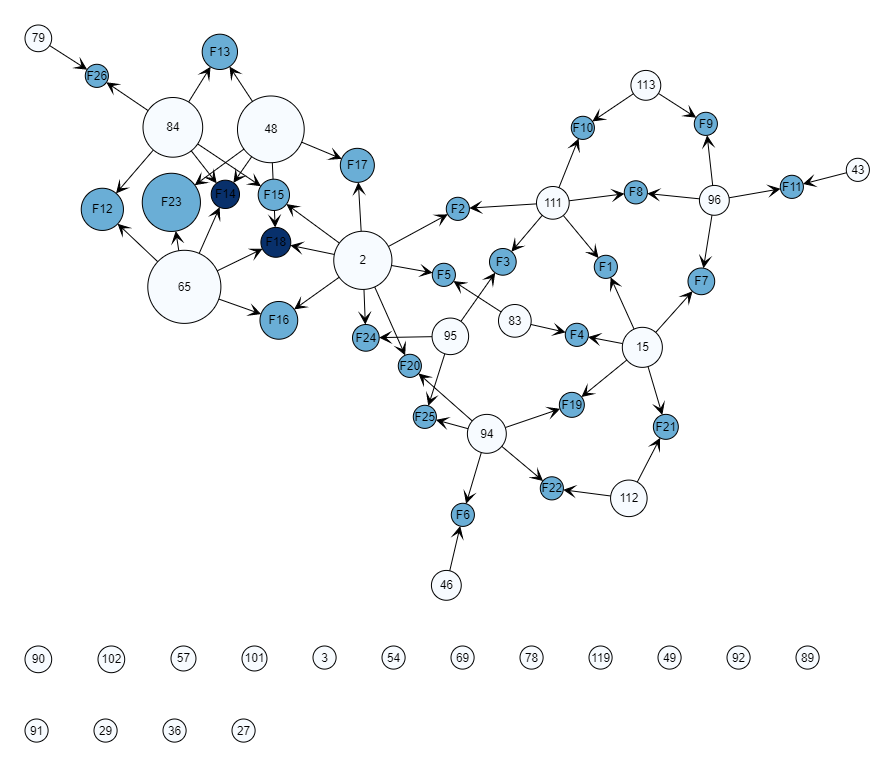

Nessa visualização, são utilizadas as seguintes convenções:
*  Os nós brancos representam os distribuidores (items) e os nós azuis representam os itemsets frequentes não unitários (conjuntos de distribuidores), com suporte superior ao mínimo, 4%.
*  Quanto mais intenso o azul, maior a cardinalidade do itemset, o seja, maior o número de distribuidores - nesse caso, o azul mais claro representa itemsets com dois distribuidores e o azul mais escuro representa itemsets com 3 distribuidores.
*  As arestas direcionadas (setas) simbolizam quais itens constituem um determinado itemset frequente.
*  Por fim, a área do nó representa o suporte do item ou itemset.

Nessa visualização podemos ver que o distribuidor 65 (BR Distribuidora) e o 48 (Ipiranga) têm o maior suporte, ou seja, estão no maior número de instalações, e formam o itemset frequente F23, igualmente com um suporte relativamente alto dentre os demais.

É possível também observar, por exemplo, que o distribuidor 2 (Alesat) está envolvido em 8 itemsets frequentes, já que há 8 arestas saindo desse nó. Esse é o distribuidor que está envolvido no maior número de itemsets frequentes.

Além do próprio fato de os distribuidores compartilharem sua infraestrutura e observarmos distribuidores que são frequentemente vistos em conjunto nas mesmas infraestruturas, demos mais um passo no sentido de identificar que esses conjuntos não ocorrem aleatoriamente.

Foi feita a identificação de regras de associação com confiança mínima de 50%, a partir do conjunto de itemsets frequentes com suporte maior que 4%. Isso gerou um total de 24 regras de associação do tipo:

> Se determinado(s) distribuidor(es) está em uma instalação, é provável (>50% de probabilidade) que outro determinado distribuidor também esteja.

Foi encontrado, em todos os casos, valor de lift superior a 1, com algumas regras com lift superior a 14. Isso significa que a ocorrência de do(s) distribuidor(es) antecedentes tem efeito positivo sobre a presença do(s) distribuidores consequentes. Ou seja, esses distribuidores aparecem mais frequentemente juntos do que o esperado caso a distribuição fosse aleatória.

Vamos utilizar agora o framework de visualização proposto também por [Ertek e Demiriz (2006)](http://research.sabanciuniv.edu/78/4/ertek_demiriz_iscis2006.pdf) para as regras de associação obtidas. Nesse caso, foi utilizado o Layout Organic, com Label Placement igual a Stretch Center e Edge Routig igual a Polyline

In [113]:
# cria as regras de associação
regras = association_rules(freq_itemsets, 
                           metric="confidence", 
                           min_threshold=conf_min)

#adiciona coluna com uma sigla para identificar cada regra
for index, row in regras.iterrows():
  regras.loc[index,'sig'] = "A"+str(index+1)

In [114]:
###########
#Cria arquivo .graphml de regras de associação
#  para ser importado no yEd para visualização do grafo
###########

#objeto da biblioteca pyyed
gra = pyyed.Graph()

#determina o mapa de cores utilizado
cmap = get_cmap('YlOrRd')

#acessório para distribuir o mapa de cores, linearmente, da regra de menor
#confiança (amarelo) para a de maior confiança (vermelho mais intenso)
norm = Normalize(vmin=regras['confidence'].min(),
                 vmax=regras['confidence'].max())

#criando nodes com itens
for index, row in freq_itemsets[freq_itemsets['tipo']=='unico'].iterrows():
  gra.add_node(str(int(row.sig)),
               shape = 'ellipse',
               shape_fill= '#FFFFFF',
               height=str(100*diam(row.support)),
               width=str(100*diam(row.support)),
               )
  
#criando nodes com regras
for index, row in regras.iterrows():
  gra.add_node(str(row.sig),
               shape = 'ellipse',
               shape_fill= to_hex(cmap(norm(row.confidence))),
               height=str(100*diam(row.support)),
               width=str(100*diam(row.support)),
               )


#criando edges lists
#edge list de antecedente para regra
antecedente = []
antec_RA = []

for index, associacao in regras.iterrows():
  for item in associacao.antecedents:
    antecedente.append(str(int(item)))
    antec_RA.append(str(associacao.sig))

for index in range(0, len(antecedente)):
  gra.add_edge(antecedente[index], antec_RA[index],
               color="#A9A9A9",
               width="1.5")

#edge list de regra para consequente
conseq_RA = []
consequente = []

for index, associacao in regras.iterrows():
  for item in associacao.consequents:
    conseq_RA.append(str(associacao.sig))    
    consequente.append(str(int(item)))

for index in range(0, len(consequente)):
  gra.add_edge(conseq_RA[index], consequente[index],
               color="#000000",
               width="1.5")


# To write to file:
with open('ra_graph.graphml', 'w') as fp:
    fp.write(gra.get_graph())

#Faz o download do arquivo .graphml para o computador local
#Esse arquivo pode ser trabalhado no yEd: https://www.yworks.com/yed-live/
files.download('ra_graph.graphml')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

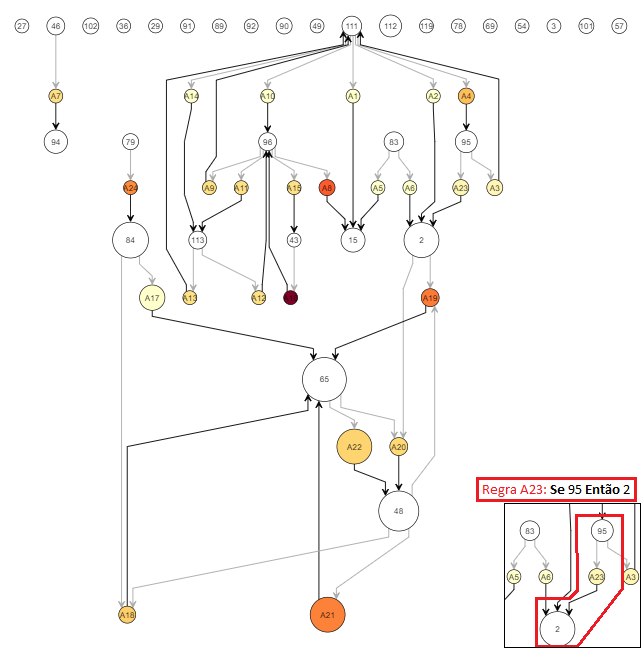

Nesse tipo de visualização são utilizadas as seguintes convenções:
*  Mais uma vez, cada distribuidor é representado por um círculo (nó) branco.
*  As regras de associação são os círculos coloridos.
*  As áreas dos nós representam o suporte.
*  As cores dos nós representam a confiança de cada regra, sendo mais claro (amarelo) para menor confiança e mais escuro (vermelho) para maior confiança.
* As arestas cinzas *chegam* aos nós de regras de associação a partir do(s) distribuidor(es) antecedente(s)
* As arestas pretas *saem* dos nós de regras com direção ao(s) distribuidor(es) consequente(s).

A visualização do grafo com layout de hierarquia ajuda a visualizar o fluxo de antecedentes/consequentes, normalmente posicionados de cima para baixo. Na aplicação original, para análise de itens comprados em um supermercado, o próprio posicionamento dos itens lado a lado ajuda a identificar, visualmente, itens que são "impulsionadores de vendas" de outros.

Na nossa aplicação, que se propõe a identificar grupos de distribuidores que potencialmente têm conduta uniforme ou colusiva no uso da infraestrutura, foi modificado o layout, de Hierarchy para Circular, como apresentado na figura a seguir:

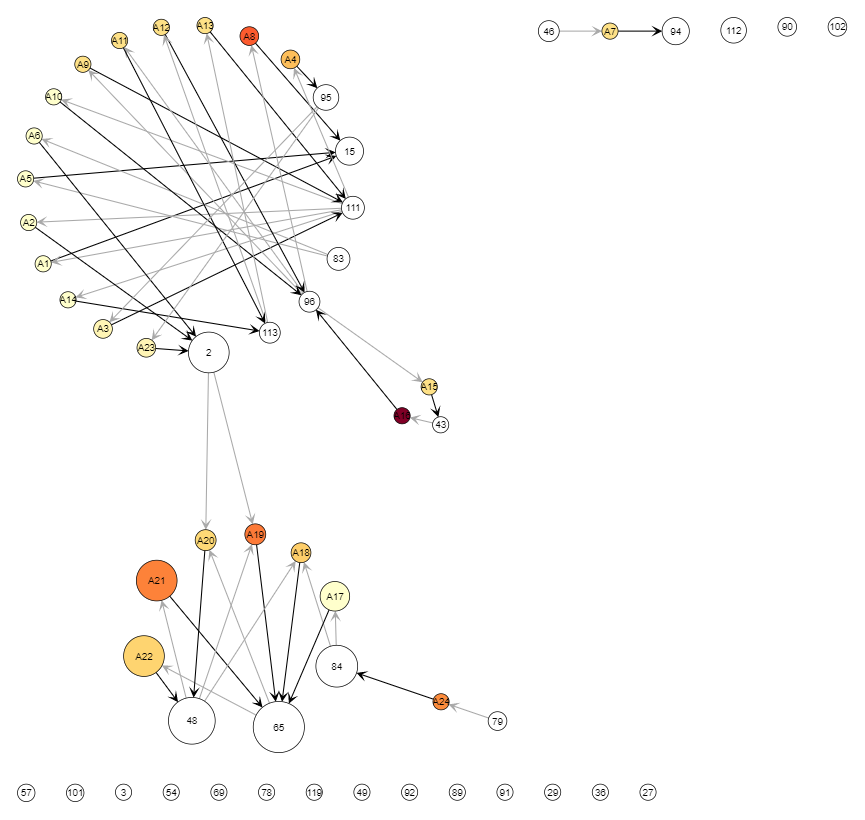

Nessa visualização permanecem válidas as mesmas convenções utilizadas na visualização anterior. A identificação de todos os antecedentes/consequentes de cada regra de associação fica um pouco prejudicada devido ao alto número de cruzamentos entre as setas. Por outro lado, nesse layout naturalmente formam-se alguns grupos de distribuidores e regras de associação que os ligam mutuamente. 

Por exemplo, se destaca na parte esquerda inferior da imagem um grupo formado pelos distribuidores 65, 48 e 84. No centro da imagem, há uma circularidade entre os distribuidores 43 e 96, que inclui a regra de maior confiança dentre todas as apuradas. Finalmente, observa-se um grupo maior, na parte superior, formada por 7 distribuidores com diversas regras de associação que os ligam.

Esse tipo de agrupamento revela um padrão frequente de compartilhamento de infraestrutura, que supera a frequência que se poderia esperar caso a distribuição das empresas nas instalações fosse aleatória, e, possivelmente, um padrão de atuação uniforme ou colusiva dos distribuidores.

Neste estudo, a utilização de ferramentas de obtenção, limpeza e mineração de dados se mostrou bastante eficaz para o mapeamento de padrões de associação entre distribuidores, a partir de uma grande base da dados de contratos de uso de infraestrutura, na qual o crescimento exponencial de combinações possíveis de elementos precisa ser superado.
Apesar de esses achados não representarem lastro probatório suficiente para atestar a existência de infração à ordem econômica, podem servir de base para estudos e investigações mais aprofundados sobre a conduta dos agentes econômicos, potencialmente concorrentes, no compartilhamento de infraestrutura de distribuição de combustíveis.